# **Airbnb and Business Problem**

<p align="justify"> 
Airbnb is an online marketplace for short-term homestays, and their business model consists of charging a commission from each booking. So they can better understand their customers behaviors and most desired booking locations a Data Scientist was hired, in order to <b> predict the five most likely countries for a USA user to make their next booking</b>. Airbnb provided data from over 200 thousand users, split in two different datasets, so the predictions could be made for around 61 thousand users. There are 12 possible outcomes of the destination country: 'USA', 'France', 'Canada', 'Great Britain', 'Spain', 'Italy', 'Portugal', 'New Zealand', 'Germany' and 'Australia', as well as 'NDF' (which means there wasn't a booking) and 'other countries'. </p>

## 1. **Imports**

#### 1.1 **Libraries**

In [1]:
import optuna
import pickle
import numpy  as np
import pandas as pd

import seaborn           as sns
import matplotlib.pyplot as plt

import umap.umap_          as umap
from sklearn.decomposition import PCA
from dython.nominal        import cramers_v
from pandas_profiling      import ProfileReport

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing   import RobustScaler, StandardScaler, LabelEncoder, MinMaxScaler, LabelBinarizer

from lightgbm             import LGBMClassifier
from xgboost.sklearn      import XGBClassifier
from sklearn.tree         import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble     import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier

#### 1.2 **Helper Functions**

In [2]:
def data_shape(df):
    '''
    Gets the number of rows and columns for a given DataFrame.

    Parameters
    ----------
    df : dataframe on which the function will be applied.
    
    Returns
    -------
    None 
    '''   
    print(f'Number of Rows: {df.shape[0]}')
    print(f'Number of Columns: {df.shape[1]}')

    return None 

def descriptive_statistics(df, num_attributes):
    '''
    Creates a descriptive statistics table.

    Parameters
    ----------
    df : dataframe on which the function will be applied.

    num_attributes: dataframes's numerical attributes.    
    
    Returns
    -------
    metrics : descriptive statistics table.
    '''
    # Central Tendency 
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
    
    # Dispersion 
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    
    # Concat
    metrics = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    metrics.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']

    return metrics

def cramers_v_heatmap(df_categorical, cols_drop=None):
    '''
    Calculates the Cramér's V correlation matrix.

    Parameters
    ----------
    df_categorical : dataframe with only categorical attributes.

    cols_drop : cols to be dropped from dataframe, usually an 'id', 'product_id', 'user_id', etc.
    
    Returns
    -------
    sns.heatmap
    '''
    if cols_drop:
        cat_att = df_categorical.drop(columns=cols_drop).columns.tolist()
    else:
        cat_att = df_categorical.columns.tolist()

    corr_dict = {}
    for i in range(len(cat_att)):
        corr_list = []
        for j in range(len(cat_att)):
            ref = cat_att[i]
            feat = cat_att[j]
            corr = cramers_v(df_categorical[ref], df_categorical[feat])
            corr_list.append(corr)

        corr_dict[ref] = corr_list

    d = pd.DataFrame(corr_dict)
    d = d.set_index(d.columns)    
    plt.figure(figsize=(10,7))
    
    return sns.heatmap(d, annot=True)     
   
def to_int_64(df,change_types_list):
    '''
    Changes data type to int64.

    Parameters
    ----------
    df : dataframe on which the function will be applied.

    change_types_list : list of columns on which the function will be applied.

    Returns
    -------
    df : dataframe with new column types.
    '''  
    for i in change_types_list:
        df[f'{i}'] = df[f'{i}'].astype('int64')

    return df

def bar_plot_values_on_top(x, y, aux, hue=None, figsize=(12,7)):
    '''
    Bar plot with values on top of each bar.

    Parameters
    ----------
    aux : auxiliary dataframe.

    x : x axis values    

    y : y axis values

    hue : multiple columns

    Returns
    -------
    ax : bar plots.
    '''   
    if hue:
        plt.figure(figsize=figsize)        
        ax = sns.barplot(x=x, y=y, hue=hue, data=aux, palette='deep')
        plt.legend(loc='upper left')
        
        for i in ax.containers:    
            ax.bar_label(i,)

        return ax

    else:
        plt.figure(figsize=figsize)
        ax = sns.barplot(x=x, y=y, data=aux, palette='deep')

        for i in ax.containers:    
            ax.bar_label(i,)

        return ax

def nature_encode(df, col, div_period):
    '''
    Applies a Nature Cyclical Transformation, where each period
    is a combination of sin and cos.
    
    Parameters
    ----------
    df : dataframe on which the function will be applied.

    col : period column on which the function will be applied.

    div_period : amount of periods until the cycle restarts (e.g. month=12, week=7, etc).

    Returns
    -------
    None
    '''  
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/div_period)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/div_period)
    return None

def dcg_score(y_true, y_score, k=5):
    '''
    Discounted cumulative gain (DCG) at rank K.
    
    Parameters
    ----------
    y_true : true relevance labels.

    y_score : predicted scores.

    k : rank k

    Returns
    -------
    score
    ''' 
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

def ndcg_score(ground_truth, predictions, k=5):
    '''
    Normalized discounted cumulative gain (NDCG) at rank K.

    Parameters
    ----------
    ground_truth : true labels represented as integers

    predictions : predicted probabilities

    k : rank k

    Returns
    -------
    score 
    '''
    lb = LabelBinarizer()
    lb.fit(range(len(predictions) + 1))
    T = lb.transform(ground_truth)
    scores = []

    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k) 
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)

def cross_validation(model, X_train, y_train, k, verbose=True):
    '''
    Splits the data into train and validation, fits the given model for each k_fold, 
    returns a DataFrame with the mean +/- std (of k models) for ndcg score @k metric.

    Parameters
    ----------
    model : ML model used.

    X_train : X training data.

    y_train: y training data.

    k = number of k folds.

    Returns
    -------
    DataFrame: Contains cross-validation ndcg score @k metric.
    '''
    # Number of k folds
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    
    # Empty list to store all metrics
    ndcg_score_list = [] 
    i = 1
    
    for train_cv, val_cv in kfold.split(X_train, y_train):
        if verbose == True:    
            print(f'Fold Number {i}/{k}') 
        else:
            pass

        # Training dataset
        X_train_fold = X_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]

        # Validation dataset
        x_val_fold = X_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]
       
        # Model
        model.fit(X_train_fold, y_train_fold)

        # Prediction
        y_pred = model.predict_proba(x_val_fold)

        # Balanced Accuracy
        ndcg = ndcg_score(y_val_fold, y_pred)
        ndcg_score_list.append(ndcg)

        i = i + 1

    return pd.DataFrame({'Model': type(model).__name__,
                         'NDCG Score': np.round(np.mean(ndcg_score_list),4).astype(str) + ' +/- ' + np.round(np.std(ndcg_score_list),4).astype(str)}, index=[0])    

def rows_to_cols(df, variable, original_col):
    '''
    Sets each value in rows from a original column to a new column.

    Parameters
    ----------
    df : dataframe on which the function will be applied.

    variable : variable
    
    original_col : original column
    
    Returns
    -------
    df : DataFrame 
    '''  
    variable_list = [variable]
    df[variable] = df[original_col].str.contains('|'.join(variable_list)).astype(int)
    df.loc[df[variable] == 1, variable] = df[original_col]
    df[variable] = df[variable].str.rsplit(',').str[-1]  
      
    return df

def feature_importances(model, X_train_n, y_train_n):
    '''
    Ranks the feature importances by using ensemble algorithms.

    Parameters
    ----------
    model : ensemble model used (e.g. Random Forest, Decision Tree, ExtraTrees, etc).

    X_train_n : X train.

    y_train_n: y train.

    Returns
    -------
    None 
    '''
    # Fitting the model
    model.fit(X_train_n, y_train_n)
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Print feature ranking
    print("Feature Ranking:\n")
    df = pd.DataFrame()
    for i, j in zip(X_train_n, model.feature_importances_):
        aux = pd.DataFrame({'feature': i , 'importance': j}, index=[0])
        df = pd.concat([df, aux], axis=0)

    print(df.sort_values('importance', ascending=False))

    # Plot the ranked features by importance
    plt.title('Feature Importances')
    plt.bar(range(X_train_n.shape[1]), importances[indices], color="b", align="center")
    plt.xticks(range(X_train_n.shape[1]), indices)
    plt.xlim([-1, X_train_n.shape[1]])
    plt.show()

    return df

def model_eval(model, X_train_ml, y_train_ml, X_test, y_test):   
    '''
    Evaluates the model in the test data by NDCG Score.

    Parameters
    ----------
    model : ML model used.

    X_train_ml : X training data.

    y_train_ml : y training data.

    X_test : x test data.

    y_test : y test data.

    Returns
    -------
    DataFrame: Contains NDCG Score.
    '''
    # Model
    model.fit(X_train_ml, y_train_ml)

    # Prediction
    y_pred = model.predict_proba(X_test)

    # NDCG Score
    ndcg = ndcg_score(y_test, y_pred)     

    return y_pred, pd.DataFrame({'Model': type(model).__name__,
                         'NDCG Score' : np.round(ndcg, 4)}, index=[0])

def top_5_pred(y_pred_proba, member_ids, label_encoder):
    '''
    Getting top 5 predictions for each user.

    Parameters
    ----------
    y_pred_proba : predicted probabilities for each class.

    member_ids : users id list.

    label_encoder: target variable label encoder.

    Returns
    -------
    DataFrame 
    '''
    users_ids = []
    predictions = []
    for i, member_id in enumerate(member_ids):
        users_ids.extend([member_id]*5)
        top_5 = np.argsort(y_pred_proba[i, :])[::-1]
        for j in range(5):
            predictions.append(label_encoder.classes_[top_5[j]])
    return pd.DataFrame({'id': users_ids, 'predicted_country': predictions})
 
# Ignoring Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)                        
pd.set_option('mode.chained_assignment', None)

# Seaborn settings
sns.set(rc={'axes.edgecolor':'#5D585E', 'axes.facecolor':'black', 'figure.facecolor':'black', 'grid.color': '#5D585E', 'text.color': 'white', 'xtick.color': 'white', 'ytick.color': 'white', 'axes.labelcolor': 'white'})

#### 1.3 **Loading Data**

In [3]:
path = 'data/'

df_users = pd.read_csv(path + 'users.csv', low_memory=True)
df_sessions = pd.read_csv(path + 'sessions.csv', low_memory=True)

df_new_users = pd.read_csv(path + 'new_users.csv', low_memory=True)
df_sessions_new_users = pd.read_csv(path + 'sessions_new_users.csv', low_memory=True)

In [4]:
df_users.sample(10)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
207025,85ncexvs6o,2014-06-19,20140619053555,NaN,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF
31927,lw9pjydgze,2012-07-14,20120714163459,2013-05-21,FEMALE,105.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari,US
78877,t5c39apcuf,2013-05-22,20130522230242,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari,NDF
67744,5tjlx2licz,2013-03-28,20130328173638,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF
11309,wl124o007v,2011-10-18,20111018072505,2011-10-20,-unknown-,NaN,basic,0,en,direct,direct,NaN,Web,Other/Unknown,-unknown-,US
172250,bh84ajntbf,2014-04-06,20140406034928,2014-04-06,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Windows Desktop,Firefox,US
144355,5py0t6imfm,2014-01-21,20140121153155,NaN,MALE,60.0,basic,0,en,seo,bing,linked,Web,Mac Desktop,Safari,NDF
50659,9o86h223jp,2012-12-01,20121201200902,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,iPad,Mobile Safari,NDF
126515,pbtqabvoxr,2013-11-21,20131121161449,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Windows Desktop,Firefox,NDF
155660,2q0ld3seau,2014-02-22,20140222170551,NaN,-unknown-,NaN,basic,0,en,sem-non-brand,google,omg,Web,Mac Desktop,Safari,NDF


In [5]:
df_sessions.sample(10)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
4647322,gpxuwhf3to,authenticate,submit,login,Mac Desktop,NaN
479024,t8e3vjhkc7,show,view,p3,Android App Unknown Phone/Tablet,4183.0
191581,q6im23dm1u,lookup,NaN,NaN,iPad Tablet,1941.0
2633828,bvrtokjt64,personalize,data,wishlist_content_update,Mac Desktop,434.0
4461621,cjvz4q1hi6,payment_instruments,data,payment_instruments,iPhone,188145.0
5415193,9j0kgehn3w,facebook_auto_login,-unknown-,-unknown-,iPhone,1564051.0
1145911,qg7uwufnpx,create,submit,create_user,Mac Desktop,NaN
5288589,quzdvmx6s7,show,view,p3,Windows Desktop,817.0
2245794,6xp6t86m4c,similar_listings,data,similar_listings,Windows Desktop,0.0
3640188,c6r1gxxx7g,index,view,message_thread,Mac Desktop,12017.0


## 2. **Data Cleaning**

In [6]:
df2 = df_users.copy()

<p>

| **Feature**          | **Definition** |
|----------------------|----------------|
|       id      | user id |
|       date_account_created      | the date of account creation | 
|       timestamp_first_active    | timestamp of the first activity, note that it can be earlier than date_account_created or date_first_booking because a user can search before signing up |
|       date_first_booking       | date of first booking |
|       gender    | user's gender |
|       age      | user's age |
|       signup_method     | method of signing up e.g. facebook, basic, google |
|       signup_flow        | the page a user came to signup up from |
|       language        | international language preference |
|       affiliate_channel        | what kind of paid marketing |
|       affiliate_provider        | where the marketing is e.g. google, craigslist, other |
|       first_affiliate_tracked        | whats the first marketing the user interacted with before the signing up |
|       signup_app        | signup app  e.g. Web, Android |
|       first_device_type        | first device type used e.g. Windows Desktop, IPhone, Android Phone|
|       first_browser        | first browser used e.g. Chrome, FireFox, Safari |
|       country_destination        | This is the target variable |

</p>
<p>

| **Feature**          | **Definition** |
|----------------------|----------------|
|       user_id      | to be joined with the column 'id' in users table |
|       action      | action performed e.g. show, search_results, confirm_email | 
|       action_type    | action type performed e.g. view, click |
|       action_detail       | action detail e.g. confirm_email_link, view_search_results |
|       device_type    | device used on each action |
|       secs_elapsed      | the time between two actions recorded |

</p>

#### 2.1. **Data dimensions**

In [7]:
data_shape(df2)

Number of Rows: 213451
Number of Columns: 16


In [8]:
data_shape(df_sessions)

Number of Rows: 5572453
Number of Columns: 6


#### 2.2. **Checking duplicates and NaN's**

In [9]:
# id duplicated values
df2.duplicated('id').sum()

# no need to check duplicated for df_sessions, since it's expected to have duplicated values

0

In [10]:
# check nan's
df2.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

2.2.1. **Dropping date_first_booking NaN's**

In [11]:
df2 = df2.drop(columns='date_first_booking')

date_first_booking needs to be dropped since it's all NaN's in the new_users dataset.

2.2.2. **age NaN's**

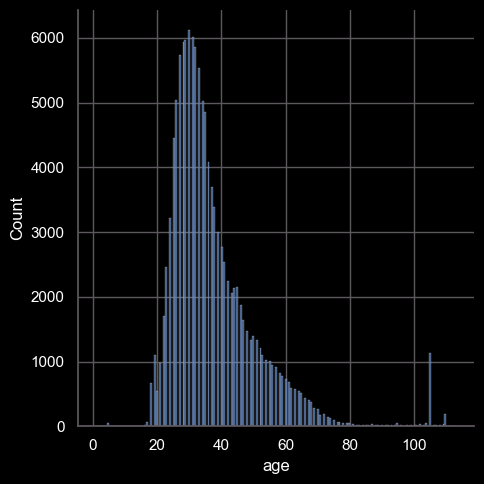

In [12]:
sns.displot(df2[df2['age'] < 115]['age'])

NaN's on 'age' will be replaced with the median of ages under 115, since ages over that value don't make much sense (full explanation in section 3.1).

In [13]:
df2['age'] = df2['age'].fillna(df2[df2['age'] < 115]['age'].median()) # fillna with age's median

2.2.3. **first_affiliate_tracked NaN's**

In [14]:
df2['first_affiliate_tracked'].value_counts()

untracked        109232
linked            46287
omg               43982
tracked-other      6156
product            1556
marketing           139
local ops            34
Name: first_affiliate_tracked, dtype: int64

NaN's on 'first_affiliate_tracked' will be replaced with 'untracked', as it would be the most logical replacement in this instance.

In [15]:
df2['first_affiliate_tracked'].fillna('untracked', inplace=True)

2.2.4. **df_sessions NaN's**

In [16]:
# check nan's
df_sessions.isna().sum()

user_id           34496
action            51678
action_type      623107
action_detail    623107
device_type           0
secs_elapsed      74363
dtype: int64

'user_id' nan's will be dropped, since there's no way to recover them, and those are necessary to merge df_sessions with df2.

In [17]:
# user_id
df_sessions.dropna(subset=['user_id'],inplace=True) # dropping id's

replacing 'secs_elapsed' nan's with zeros, so it can be recovered

In [18]:
# secs_elapsed
df_sessions['secs_elapsed'].fillna(0, inplace=True)

Latter on, only one of action, action_type and action_detail will be kept, since they represent very similar events. In this case, action_type was chosen because it has way fewer unique values in comparison to action and action_detail. (Full explanation in section 2.6). 

**Therefore, since both 'action_type' and 'action' represent similar events, all 'action_type' nan's will be replaced with 'action' values, in order to recover this information.**

In [19]:
# action_type
df_sessions['action_type'] = np.where(df_sessions['action_type'].isnull(), df_sessions['action'], df_sessions['action_type'])

In [20]:
# check nan's now
df_sessions.isna().sum()

user_id               0
action            51532
action_type           0
action_detail    619860
device_type           0
secs_elapsed          0
dtype: int64

In [21]:
data_shape(df_sessions)

Number of Rows: 5537957
Number of Columns: 6


#### 2.3. **Changing data types and renaming rows**

We'll set all rows to snake_case. Some data types will need to be changed. 

In [22]:
df2.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [23]:
# date_account_created
df2['date_account_created'] = pd.to_datetime(df2['date_account_created']) # convert to datetime

# timestamp_first_active
df2['timestamp_first_active'] = pd.to_datetime(df2['timestamp_first_active'], format='%Y%m%d%H%M%S') # convert to datetime

# age
df2['age'] = df2['age'].astype('int64')

# signup_flow
df2['signup_flow'] = df2['signup_flow'].astype('int64')

# other variables have correct dtypes already

In [24]:
df_sessions.dtypes # all dtypes are ok here

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

#### 2.4. **Checking data balance**

In [25]:
df2['country_destination'].value_counts(normalize=True)

NDF      0.583473
US       0.292226
other    0.047290
FR       0.023532
IT       0.013282
GB       0.010888
ES       0.010536
CA       0.006690
DE       0.004971
NL       0.003570
AU       0.002525
PT       0.001017
Name: country_destination, dtype: float64

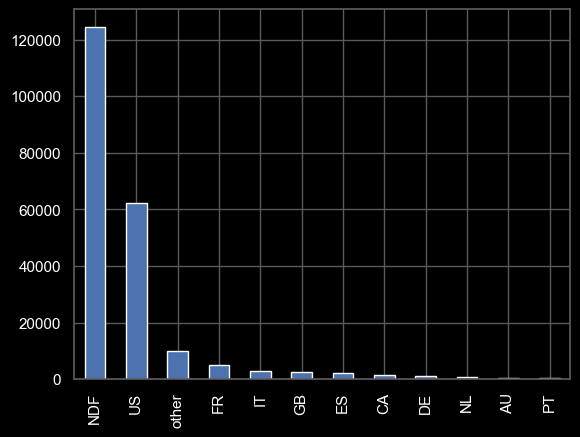

In [26]:
df2['country_destination'].value_counts().sort_values(ascending=False).plot(kind='bar');

The data is quite unbalanced, as the percentage of people that didn't decide a destination (ndf) + USA destinations is about 87,41% of the data. **Balancing techniques were used, however we chose not to use the balanced data for modeling. The explanation is available in the final section named Appendix : Data Balance**.

#### 2.5. **Descriptive statistics**

2.5.1. **df2 - Numerical**

In [27]:
df2_num_attributes = df2.select_dtypes(include=['int64', 'float'])
descriptive_statistics(df2, df2_num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,1.0,2014.0,2013.0,43.209444,34.0,119.592517,16.263619,264.656719
1,signup_flow,0.0,25.0,25.0,3.267387,0.0,7.637689,2.234366,3.324444


Inconsistencies: 

- age = 2014 years

*This will be dealt with in the Feature Filtering section.*

2.5.2. **df2 - Categorical**

In [28]:
df2_cat_attributes = df2.select_dtypes(exclude=['int64', 'float', 'datetime64[ns]'])
df2_cat_attributes.drop(columns=['id']).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,213451,213451,213451,213451,213451,213451,213451,213451,213451,213451
unique,4,3,25,8,18,7,4,9,52,12
top,-unknown-,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,95688,152897,206314,137727,137426,115297,182717,89600,63845,124543


2.5.3. **df_sessions - Numerical**

In [29]:
df_sessions_num_attributes = df_sessions.select_dtypes(include=['int64', 'float'])
descriptive_statistics(df_sessions, df_sessions_num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,secs_elapsed,0.0,1799977.0,1799977.0,20183.120508,1100.0,92020.328319,10.737987,143.526459


2.5.4. **df_sessions - Categorical**

In [30]:
df_sessions_cat_attributes = df_sessions.select_dtypes(exclude=['int64', 'float', 'datetime64[ns]'])
df_sessions_cat_attributes.drop(columns=['user_id']).describe()

,action,action_type,action_detail,device_type
count,5486425,5537957,4918097,5537957
unique,331,26,128,14
top,show,view,view_search_results,Mac Desktop
freq,1301904,1669723,912787,2150595


An interesting technique to use whenever categorical variable have many unique values (such as df_sessions' categorical variables) is to check whether these variables have high correlation amongst them. It can be done via Cramér's V correlation matrix: 

In [31]:
# cramers_v_heatmap(df_sessions_cat_attributes.drop(columns=['user_id']))

Obs:
- action, action_type, action_detail have high correlation.

#### 2.6. **Merging df_sessions and df2**

- Out of action, action_type, action_detail only **action_type** will be kept due to their high correlation and because they seem to represent similar events. **action_type** was chosen because it has only 28 unique values, unlike action and action_detail that have hundreds.
- **device_type** is already being represented by first_device_type variable in df2, therefore it won't be used.
- **secs_elapsed** will be split in min, max, mean, median, sum, standard deviation and count, which would be the amount of sessions a user was in. Afterwards, each one of these variables will be added in df2.

The merging will happen after the Feature Engineering section.

In [32]:
df_sessions['action_type'].value_counts() # 28 unique values for action_type

view                     1669723
data                     1188495
click                    1064436
-unknown-                 564803
submit                    357371
show                      356164
lookup                    136212
track_page_view            63338
message_post               55567
campaigns                  39760
similar_listings_v2        13577
booking_request            10695
index                       7029
partner_callback            7005
uptodate                    2116
localization_settings        771
signed_out_modal             475
currencies                   156
update                        85
widget                        75
check                         69
phone_verification            15
satisfy                        8
disaster_action                6
track_activity                 4
booking_response               2
Name: action_type, dtype: int64

In [33]:
cols_drop_df_sessions = ['action', 'action_detail', 'device_type']
df_sessions = df_sessions.drop(cols_drop_df_sessions, axis=1).rename(columns={'user_id' : 'id'}) # renaming user_id to id also

## 3. **Feature Filtering** 

In [34]:
df3 = df2.copy()

Only one variable to be looked into : **age**.

In [35]:
df3.loc[(df3['age'] > 115)].sort_values(by='age')

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
156511,4g0g1d35cj,2014-02-25,2014-02-25 00:20:03,FEMALE,132,basic,0,en,sem-brand,google,omg,Web,iPad,Mobile Safari,US
144698,p0v67hph24,2014-01-22,2014-01-22 06:55:06,FEMALE,150,facebook,12,en,api,other,untracked,iOS,iPad,-unknown-,other
198888,io7z9esqaj,2014-06-03,2014-06-03 07:49:58,MALE,1924,facebook,23,en,direct,direct,untracked,Android,Other/Unknown,-unknown-,US
180995,sraouk5dve,2014-04-27,2014-04-27 01:04:27,FEMALE,1924,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,US
114599,92k02vn9xz,2013-10-06,2013-10-06 03:12:10,MALE,1925,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39879,vp4bsyc33e,2012-09-07,2012-09-07 02:30:57,MALE,2014,basic,3,en,sem-brand,google,omg,Web,Windows Desktop,AOL Explorer,NDF
40162,dhxdxe5po2,2012-09-09,2012-09-09 16:02:35,MALE,2014,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE,US
40274,lngpq5mcvd,2012-09-10,2012-09-10 05:32:05,MALE,2014,facebook,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,US
38017,y74p0dh11s,2012-08-25,2012-08-25 18:39:26,MALE,2014,basic,0,en,direct,direct,linked,Web,Mac Desktop,Safari,NDF


Over 700 people over 115 years old seems unreasonable. If we look further in, there seems to be a mistake when registering these people, where the age is actually the year they were born, as seen above. For them we'll be replacing their age with 2015 (year of this dataset) minus the age present on the age column.

In [36]:
df3['age'] = df3['age'].apply(lambda x: (2015 - x) if x > 1900 else x)

Now let's check if there're still people over 115.

In [37]:
df3.loc[(df3['age'] > 115)] 

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
144698,p0v67hph24,2014-01-22,2014-01-22 06:55:06,FEMALE,150,facebook,12,en,api,other,untracked,iOS,iPad,-unknown-,other
156511,4g0g1d35cj,2014-02-25,2014-02-25 00:20:03,FEMALE,132,basic,0,en,sem-brand,google,omg,Web,iPad,Mobile Safari,US


There're still two people with typos in the age column: 150 and 132 years old. They we'll be removed. In addition to that, people under 12 will be removed, since it seems unreasonable for a one year old to book a destination, for instance. 

In [38]:
df3 = df3[(df3['age'] > 12) & (df3['age'] < 115)]

## 4. **Feature Engineering**

In [39]:
df4 = df3.copy()

#### 4.1. **df4**

In [40]:
############################ # days_active_to_account - Days from first active up to account creation ############################

df4['first_active'] = pd.to_datetime(df4['timestamp_first_active'].dt.strftime('%Y-%m-%d'))
df4['days_active_to_account'] = (df4['date_account_created'] - df4['first_active']).apply(lambda x: x.days) 

##########################################################  first_active #########################################################

# year first active
df4['year_first_active'] = df4['first_active'].dt.year

# month first active
df4['month_first_active'] = df4['first_active'].dt.month

# day first active
df4['day_first_active'] = df4['first_active'].dt.day

# day of week first active
df4['day_of_week_first_active'] = df4['first_active'].dt.dayofweek

# week of year first active
df4['week_of_year_first_active'] = df4['first_active'].dt.isocalendar().week

########################################################  account_created ########################################################

# year account_created
df4['year_account_created'] = df4['date_account_created'].dt.year

# month account_created
df4['month_account_created'] = df4['date_account_created'].dt.month

# day account_created
df4['day_account_created'] = df4['date_account_created'].dt.day

# day of week account_created
df4['day_of_week_account_created'] = df4['date_account_created'].dt.dayofweek

# week of year account_created
df4['week_of_year_account_created'] = df4['date_account_created'].dt.isocalendar().week

# convert to int64
df4 = to_int_64(df4, ['year_first_active', 'year_account_created', 'week_of_year_account_created', 'week_of_year_first_active'])

# removing auxiliary columns
cols_drop_aux = ['date_account_created', 'timestamp_first_active', 'first_active'] 
df4 = df4.drop(cols_drop_aux, axis=1)

#### 4.2. **df_sessions**

**secs_elapsed** -> min, max, mean, median, sum, standard deviation and amount of sessions.

In [41]:
df_ref_sessions = (df_sessions[['id', 'secs_elapsed']].groupby('id').agg(secs_elapsed_min = ('secs_elapsed', 'min'),
                                                                         secs_elapsed_max = ('secs_elapsed', 'max'),
                                                                         secs_elapsed_mean = ('secs_elapsed', 'mean'),
                                                                         secs_elapsed_median = ('secs_elapsed', 'median'),
                                                                         secs_elapsed_sum = ('secs_elapsed', 'sum'),
                                                                         secs_elapsed_std = ('secs_elapsed', 'std'),
                                                                         amount_of_sessions = ('secs_elapsed', 'count'))).reset_index()

df_ref_sessions['secs_elapsed_std'].fillna(0, inplace=True) # fill secs_elapsed_std nan's with zeros

**action_type** -> **most common value for each user, unique values for each user and ratio of unique for each user** will be extracted. A reference table will be crated for each one of these features, so it can be latter merged in the users dataframe.

In [42]:
aux = df_sessions[['id', 'action_type']]

# most common
aux_most_common = aux.groupby('id').value_counts().reset_index()
df_ref_most_common = aux_most_common.groupby('id').max().reset_index().rename(columns={'action_type' : 'action_type_most_common'}).drop(columns=0) 

# unique
df_ref_unique = aux.groupby('id').nunique().reset_index().rename(columns={'action_type' : 'action_type_unique'})

In [43]:
# ratio of unique 
df_ref_unique_ratio = aux.groupby('id').value_counts(normalize=True).reset_index().rename(columns={0 : 'unique_ratio'}) 

df_ref_unique_ratio['action_type_unique_ratio'] = df_ref_unique_ratio['action_type'] + ',' + df_ref_unique_ratio['unique_ratio'].astype(str) # adding both columns together

for i in df_ref_unique_ratio['action_type'].unique():
    rows_to_cols(df_ref_unique_ratio, i, 'action_type_unique_ratio') # this function is available in the helper functions section

df_ref_unique_ratio = df_ref_unique_ratio.drop(columns=['action_type', 'unique_ratio', 'action_type_unique_ratio']).fillna(0) # fill nan's with zeros and drops auxiliary columns
df_ref_unique_ratio = df_ref_unique_ratio.add_prefix('action_type_ratio_').rename(columns={'action_type_ratio_id' : 'id'}) # adding action_type_ratio prefix to all columns

for i in df_ref_unique_ratio.columns.drop('id'):
    df_ref_unique_ratio[i] = df_ref_unique_ratio[i].astype(float) # convert all to float

df_ref_unique_ratio = df_ref_unique_ratio.groupby('id').max().reset_index() # .max() so we could get rid of the duplicated id's and still get each correct value

In [44]:
df_ref_unique_ratio # displaying just this ref table, since it took a lot of operations

,id,action_type_ratio_view,action_type_ratio_data,action_type_ratio_click,action_type_ratio_show,action_type_ratio_message_post,action_type_ratio_partner_callback,action_type_ratio_booking_request,action_type_ratio_-unknown-,action_type_ratio_submit,...,action_type_ratio_signed_out_modal,action_type_ratio_uptodate,action_type_ratio_check,action_type_ratio_update,action_type_ratio_phone_verification,action_type_ratio_widget,action_type_ratio_booking_response,action_type_ratio_satisfy,action_type_ratio_disaster_action,action_type_ratio_track_activity
0,00023iyk9l,0.525000,0.225000,0.100000,0.075000,0.025000,0.025,0.025000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,001wyh0pz8,0.088889,0.022222,0.733333,0.022222,0.000000,0.000,0.000000,0.066667,0.033333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0028jgx1x1,0.483871,0.161290,0.290323,0.000000,0.000000,0.000,0.000000,0.032258,0.032258,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,002qnbzfs5,0.273764,0.177440,0.177440,0.008872,0.020279,0.000,0.001267,0.233207,0.019011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0035hobuyj,0.112474,0.083845,0.421268,0.047035,0.006135,0.000,0.000000,0.018405,0.008180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73810,zzx5wp3lqu,0.230769,0.153846,0.288462,0.038462,0.019231,0.000,0.000000,0.230769,0.038462,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73811,zzy7t0y9cm,0.125000,0.375000,0.250000,0.125000,0.000000,0.000,0.000000,0.000000,0.125000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73812,zzysuoqg6x,0.000000,0.333333,0.000000,0.000000,0.000000,0.000,0.000000,0.333333,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73813,zzywmcn0jv,0.176471,0.254902,0.274510,0.156863,0.039216,0.000,0.000000,0.039216,0.058824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
# merging back to df_sessions
df_sessions = df_sessions[['id']].drop_duplicates().reset_index(drop=True)
df_sessions = pd.merge(df_sessions, df_ref_most_common, on='id', how='inner')
df_sessions = pd.merge(df_sessions, df_ref_unique, on='id', how='inner')
df_sessions = pd.merge(df_sessions, df_ref_unique_ratio, on='id', how='inner').rename(columns={'action_type_ratio_-unknown-': 'action_type_ratio_unknown'}) # postgresql doesn't accept this character: '-'
df_sessions = pd.merge(df_sessions, df_ref_sessions, on='id', how='inner')

## 5. **Merging and Splitting**

In [46]:
df5 = df4.copy()

#### 5.1. **Merging df_sessions and df5**

In [47]:
df5 = pd.merge(df5, df_sessions, on='id', how='inner')
df5

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,...,action_type_ratio_satisfy,action_type_ratio_disaster_action,action_type_ratio_track_activity,secs_elapsed_min,secs_elapsed_max,secs_elapsed_mean,secs_elapsed_median,secs_elapsed_sum,secs_elapsed_std,amount_of_sessions
0,d1mm9tcy42,MALE,62,basic,0,en,sem-non-brand,google,omg,Web,...,0.0,0.0,0.0,0.0,606881.0,26988.417323,947.0,3427529.0,69127.591524,127
1,yo8nz8bqcq,-unknown-,34,basic,0,en,direct,direct,untracked,Web,...,0.0,0.0,0.0,0.0,115983.0,23093.555556,4080.0,207842.0,37975.174098,9
2,4grx6yxeby,-unknown-,34,basic,0,en,sem-brand,google,omg,Web,...,0.0,0.0,0.0,0.0,336801.0,70965.250000,60587.5,1135444.0,91377.220627,16
3,ncf87guaf0,-unknown-,34,basic,0,en,direct,direct,linked,Web,...,0.0,0.0,0.0,0.0,732296.0,24704.605263,1569.5,3755100.0,84140.105214,152
4,4rvqpxoh3h,-unknown-,34,basic,25,en,direct,direct,untracked,iOS,...,0.0,0.0,0.0,0.0,886.0,319.375000,195.5,2555.0,325.212870,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73691,zxodksqpep,MALE,32,basic,0,en,sem-brand,google,omg,Web,...,0.0,0.0,0.0,0.0,1445590.0,46739.963636,1686.5,5141396.0,166237.234458,110
73692,mhewnxesx9,-unknown-,34,basic,0,en,direct,direct,linked,Web,...,0.0,0.0,0.0,0.0,748658.0,12096.319328,563.0,2878924.0,60030.505588,238
73693,6o3arsjbb4,-unknown-,32,basic,0,en,direct,direct,untracked,Web,...,0.0,0.0,0.0,0.0,149128.0,19054.555556,1278.5,342982.0,42591.771128,18
73694,jh95kwisub,-unknown-,34,basic,25,en,other,other,tracked-other,iOS,...,0.0,0.0,0.0,0.0,66636.0,4554.786667,2272.0,341609.0,8925.899713,75


It isn't a problem to keep only the users that have df_sessions data (about 73 thousand users), since the new variables extracted from df_sessions are quite useful when modeling (as proved in the 8. Feature Selection section).

#### 5.2. **Train Test Split**

To understand why the train-test split is being done this early on, it's firstly important to understand the meaning of **Data Leakage** in Data Science. Data Leakage can occur whenever a transformation is applied to the entire dataset before splitting the dataset in train and test, because unexpected extra information can be leaked into the test dataset. For instance, if target encoding is performed before the data split an important information is leaked into the test dataset.

In [48]:
# Split
X = df5.drop(columns=['country_destination'])
y = df5['country_destination'].copy()

x_train, x_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=42
)

# Concat
df_train = pd.concat([x_train, y_train], axis = 1)
df_test = pd.concat([x_test, y_test], axis = 1) # this will only be used in the end, for evaluating the final model

## 6. **Exploratory Data Analysis (EDA)**

EDA main objectives are:
- Obtain business experience.
- Validate business hypotheses (insights).
- Find important features for the ML model. 

In [49]:
df_eda = df4.copy() # EDA is done in the full data, not only df_train
df6 = df_train.copy() # univariate and multivariate analysis is done in df_train

#### 6.1. **Univariate Analysis**

The Profile Report will be used to check distributions, as well as outliers and other inconsistencies in the data, so those could be dealt with. 

In [50]:
# profile = ProfileReport(df6, title='Univariate Analysis', minimal=True)
# profile.to_file('report.html')

Regarding distributions, the following variables followed a close to **normal** distribution:
- action_type_unique
- action_type_ratio_view
- action_type_ratio_data

While the following variables followed a close to **exponential-logarithmic** distribution:
- action_type_ratio_click
- action_type_ratio_show
- action_type_ratio_message_post
- action_type_ratio_booking_request
- action_type_ratio_-unknown-
- action_type_ratio_submit
- action_type_ratio_campaigns
- action_type_ratio_lookup
- secs_elapsed_max
- secs_elapsed_mean
- secs_elapsed_sum
- secs_elapsed_std
- amount_of_sessions

Finally, the following variables weren't close to any known distribution:
- age
- signup_flow
- days_active_to_account
- year_first_active
- month_first_active
- day_first_active
- day_of_week_first_active
- week_of_year_first_active
- year_account_created
- month_account_created
- day_account_created
- day_of_week_account_created
- week_of_year_account_created
- action_type_ratio_index
- action_type_ratio_partner_callback
- action_type_ratio_track_page_view
- action_type_ratio_similar_listings_v2
- action_type_ratio_localization_settings
- action_type_ratio_currencies
- action_type_ratio_signed_out_modal
- action_type_ratio_uptodate
- action_type_ratio_check
- action_type_ratio_update
- action_type_ratio_phone_verification
- action_type_ratio_widget
- action_type_ratio_booking_response
- action_type_ratio_satisfy
- action_type_ratio_disaster_action
- action_type_ratio_track_activity
- secs_elapsed_min
- secs_elapsed_median

**The following numerical variables will be manually removed, since they have either 99 or 100% zeros in them, meaning they won't carry much information, therefore it won't be useful in modeling:**
- action_type_ratio_localization_settings
- action_type_ratio_currencies
- action_type_ratio_signed_out_modal
- action_type_ratio_uptodate
- action_type_ratio_check
- action_type_ratio_update
- action_type_ratio_phone_verification
- action_type_ratio_widget
- action_type_ratio_booking_response
- action_type_ratio_satisfy
- action_type_ratio_disaster_action
- action_type_ratio_track_activity
- days_active_to_account
- secs_elapsed_min

**The following categorical variables will be manually removed, since they have either 99 or 100% of the same value, meaning they won't carry much information, therefore it won't be useful in modeling:**
- year_first_active
- year_account_created

In [51]:
cols_drop = ['id', # no need for the id anymore
             'action_type_ratio_localization_settings',
             'action_type_ratio_currencies',
             'action_type_ratio_signed_out_modal',
             'action_type_ratio_uptodate',
             'action_type_ratio_check',
             'action_type_ratio_update',
             'action_type_ratio_phone_verification',
             'action_type_ratio_widget',
             'action_type_ratio_booking_response',
             'action_type_ratio_satisfy',
             'action_type_ratio_disaster_action',
             'action_type_ratio_track_activity',
             'days_active_to_account',
             'year_first_active',
             'year_account_created',
             'secs_elapsed_min']

df6 = df6.drop(cols_drop, axis=1)             

#### 6.2. **Bivariate - Checking Hypotheses**

##### **H1:** For destinations other than USA, Apple devices are used over two times in comparison to other devices, such as Windows desktop or Android phones for instance.
**FALSE**: Apple devices are used 25.74% more in comparison to other devices, for destinations other than USA.


<AxesSubplot: xlabel='first_device_type', ylabel='times_used'>

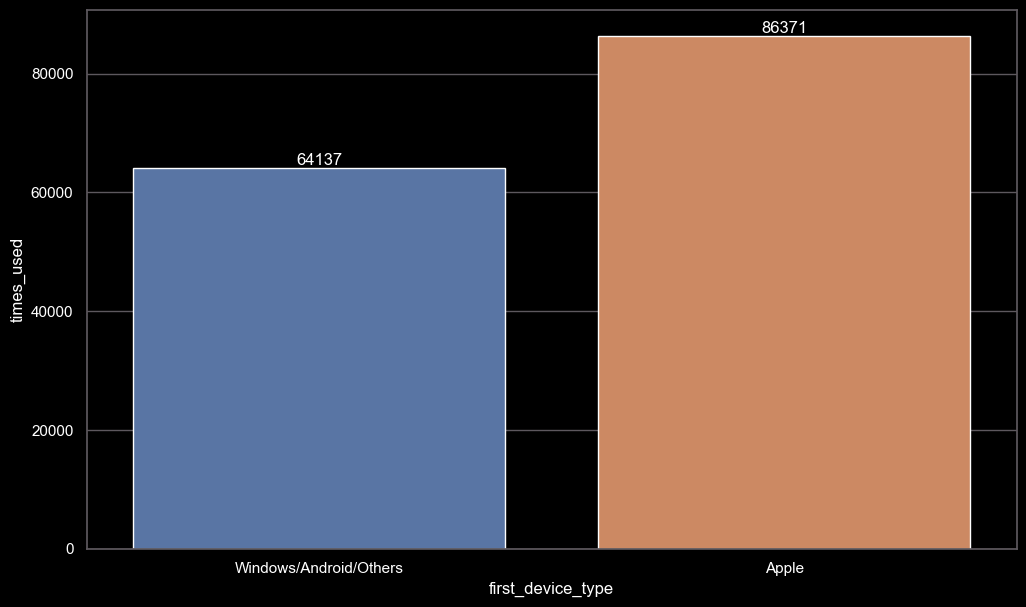

In [52]:
aux = df_eda[df_eda['country_destination'] != 'US']
aux = aux[['first_device_type', 'country_destination']].groupby('first_device_type').count().reset_index().rename(columns={'country_destination': 'times_used'})

# Windows/Android/Others
android_windows_others = ['Android Phone', 'Android Tablet', 'Desktop (Other)', 'Other/Unknown', 'SmartPhone (Other)', 'Windows Desktop']
aux2 = pd.DataFrame(aux[aux['first_device_type'].isin(android_windows_others)].sum()).T
aux2 = aux2.set_axis(['Windows/Android/Others'], axis='rows').drop('first_device_type', axis=1)
aux2 = aux2.reset_index().rename(columns={'index' : 'first_device_type'})

# Apple
apple = ['Mac Desktop', 'iPad', 'iPhone']
aux3 = pd.DataFrame(aux[aux['first_device_type'].isin(apple)].sum()).T  
aux3 = aux3.set_axis(['Apple'], axis='rows').drop('first_device_type', axis=1)
aux3 = aux3.reset_index().rename(columns={'index' : 'first_device_type'})

# Concat
aux = pd.concat([aux2, aux3])

# Plot
bar_plot_values_on_top(x='first_device_type', y='times_used', aux=aux)

In [53]:
pct = round((aux.loc[aux['first_device_type']=='Apple', 'times_used'].values[0] - aux.loc[aux['first_device_type']=='Windows/Android/Others', 'times_used'].values[0])/aux.loc[aux['first_device_type']=='Apple', 'times_used'].values[0]*100, 2)
print(f'Apple devices are used {pct}% more in comparison to other devices, for destinations other than USA.')

Apple devices are used 25.74% more in comparison to other devices, for destinations other than USA.


##### **H2:** Considering all destinations, users take less than 2 days, on average, from first active in the platform to creating an account.
**TRUE**: Users take less than 2 days, on average, from first active in the platform to creating an account, considering all destinations.

<AxesSubplot: xlabel='country_destination', ylabel='avg_days_active_to_account'>

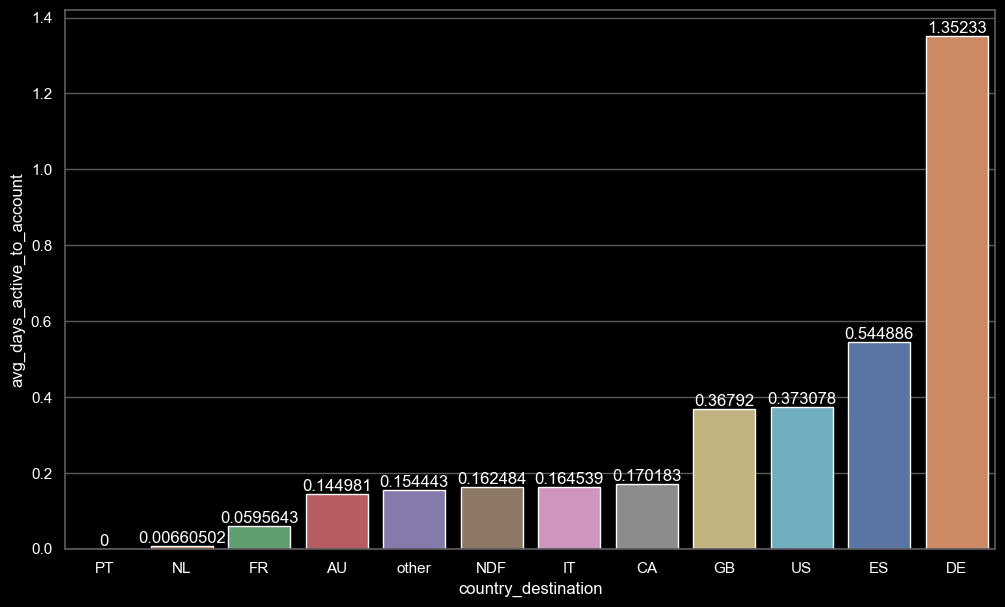

In [54]:
aux = df_eda[['days_active_to_account', 'country_destination']].groupby('country_destination').mean().reset_index().rename(columns={'days_active_to_account': 'avg_days_active_to_account'})
bar_plot_values_on_top(x='country_destination', y='avg_days_active_to_account', aux=aux.sort_values(by='avg_days_active_to_account'))

##### **H3:** There are 20% more accounts being created during the summer.
**FALSE**: The number of accounts created goes up during the spring.

<AxesSubplot: xlabel='month_account_created', ylabel='number_of_accounts_created'>

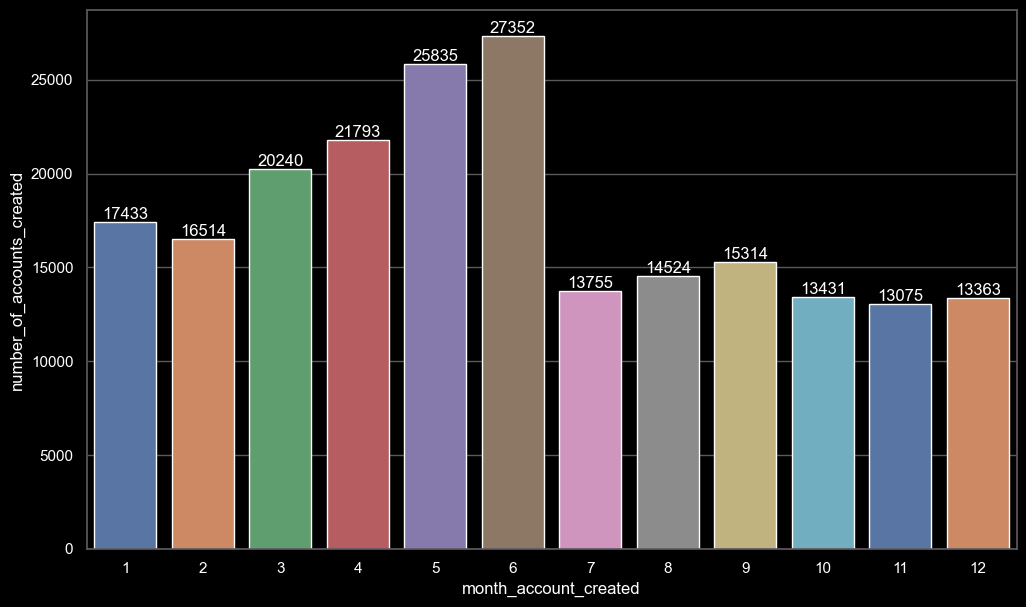

In [55]:
aux = df_eda[['month_account_created', 'country_destination']].groupby('month_account_created').count().reset_index().rename(columns={'country_destination': 'number_of_accounts_created'})
bar_plot_values_on_top(x='month_account_created', y='number_of_accounts_created', aux=aux)

##### **H4:** Women made over 10% more bookings for countries other than USA, in comparison to men.
**TRUE**: Women made over 15% more bookings for countries other than USA, in comparison to men.

<AxesSubplot: xlabel='gender', ylabel='bookings_countries_other_than_usa'>

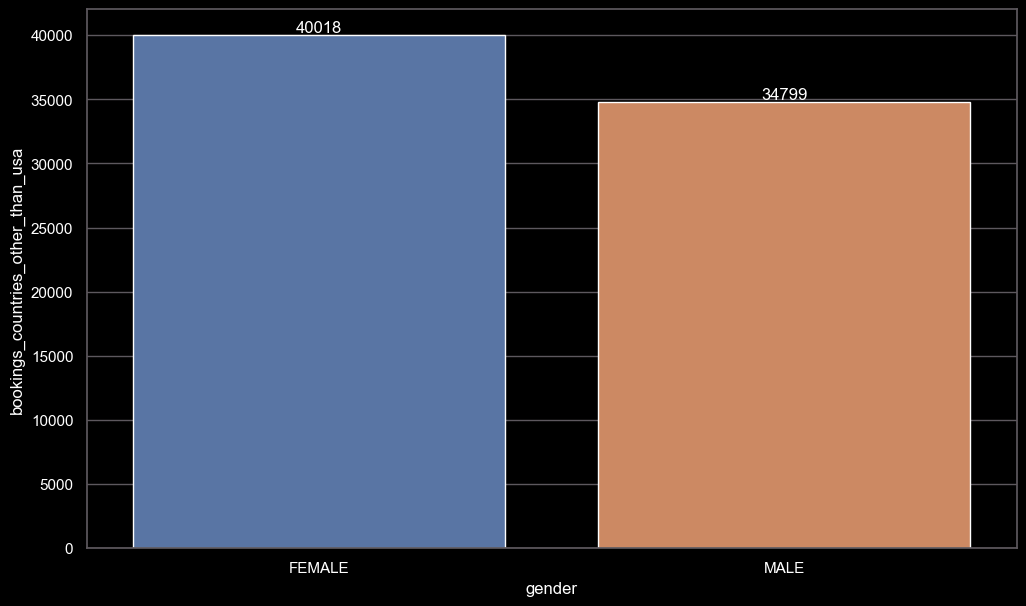

In [56]:
aux = df_eda[(df_eda['country_destination'] != 'US') & (df_eda['gender'].isin(['MALE', 'FEMALE']))]
aux = aux[['gender', 'country_destination']].groupby('gender').count().reset_index().rename(columns={'country_destination': 'bookings_countries_other_than_usa'})
bar_plot_values_on_top(x='gender', y='bookings_countries_other_than_usa', aux=aux)

##### **H5:** Google's marketing channel stands for around 40% of bookings for countries other than USA.
**FALSE**: Google's marketing channel stands for around 25% of bookings for countries other than USA.

<AxesSubplot: xlabel='affiliate_provider', ylabel='bookings_countries_other_than_usa'>

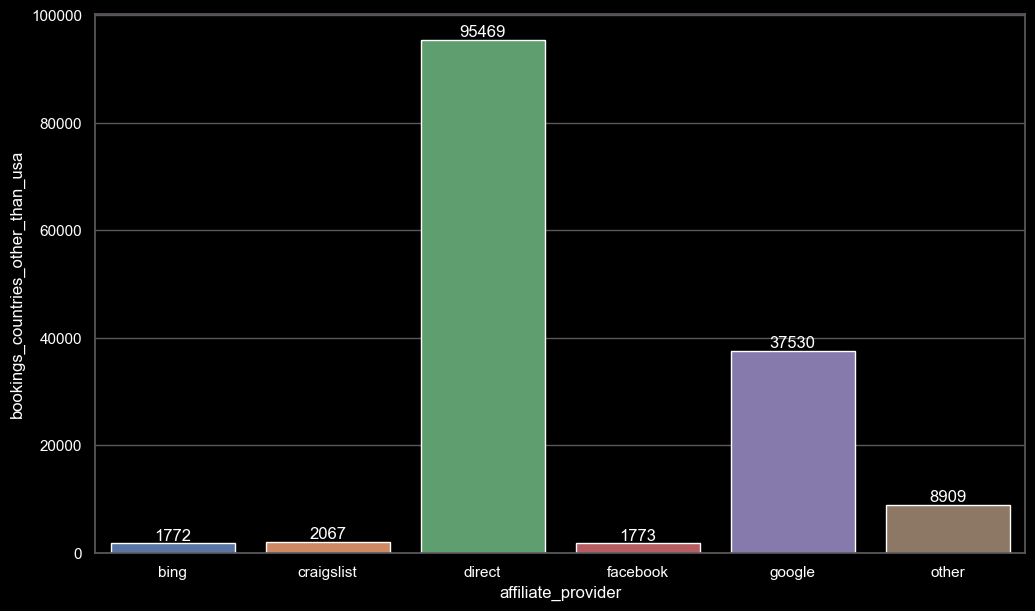

In [57]:
aux = df_eda[(df_eda['country_destination'] != 'US')]
aux = aux[['affiliate_provider', 'country_destination']].groupby('affiliate_provider').count().reset_index().rename(columns={'country_destination': 'bookings_countries_other_than_usa'})

# because there were 18 different channels the ones with less than 1000 bookings_countries_other_than_usa were all put together with the 'other' section
others_list = aux.loc[aux['bookings_countries_other_than_usa'] < 1000, 'affiliate_provider'].to_list()
others_sum = aux.loc[aux['bookings_countries_other_than_usa'] < 1000, 'bookings_countries_other_than_usa'].sum()
aux2 = aux.loc[(~aux['affiliate_provider'].isin(others_list))]
aux2 = aux2.assign(bookings_countries_other_than_usa=aux2['bookings_countries_other_than_usa'].replace(8353, 8353 + others_sum))

bar_plot_values_on_top(x='affiliate_provider', y='bookings_countries_other_than_usa', aux=aux2)

In [58]:
pct = round(aux2.loc[aux2['affiliate_provider']=='google', 'bookings_countries_other_than_usa'].values[0]/aux2['bookings_countries_other_than_usa'].sum()*100, 2)
print(f'Googles marketing channel stands for around {pct}% of bookings for countries other than USA.')

Googles marketing channel stands for around 25.44% of bookings for countries other than USA.


##### **H6:** Users average age is between 30 to 40, across all destinations.
**TRUE**: Users average age is between 35 to 38, across all destinations.

<AxesSubplot: xlabel='country_destination', ylabel='avg_age'>

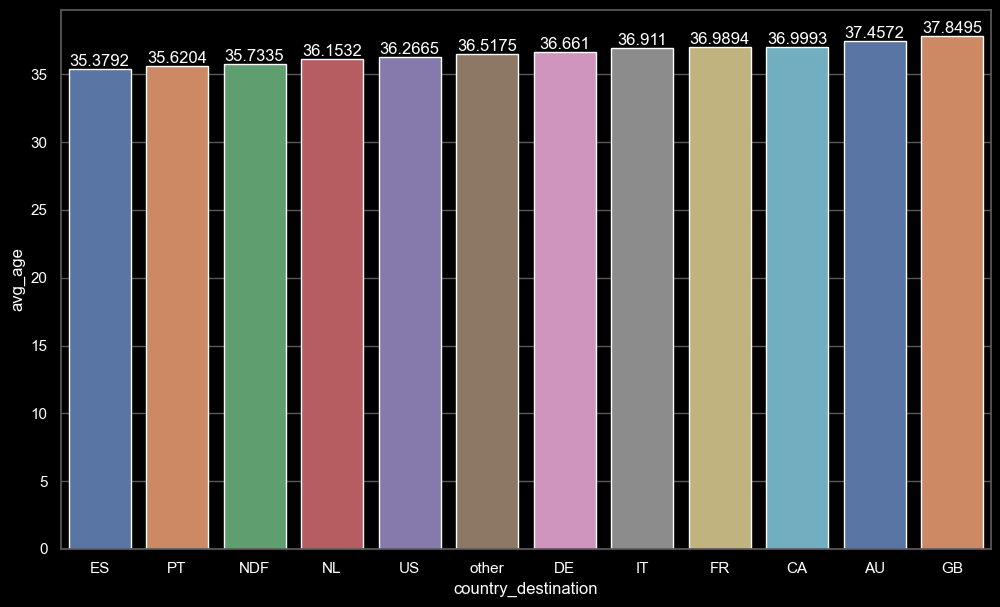

In [59]:
aux = df_eda[['age', 'country_destination']].groupby('country_destination').mean().reset_index().rename(columns={'age': 'avg_age'})
bar_plot_values_on_top(x='country_destination', y='avg_age', aux=aux.sort_values(by='avg_age'))

##### **H7:** The percentage of people that use american-english as the language to book their reservations is greater than 90%, across all destinations. 
**TRUE**: The percentage of people that use american-english as the language to book their reservations is 96%, across all destinations.

<AxesSubplot: xlabel='language', ylabel='amount_of_each_language_used'>

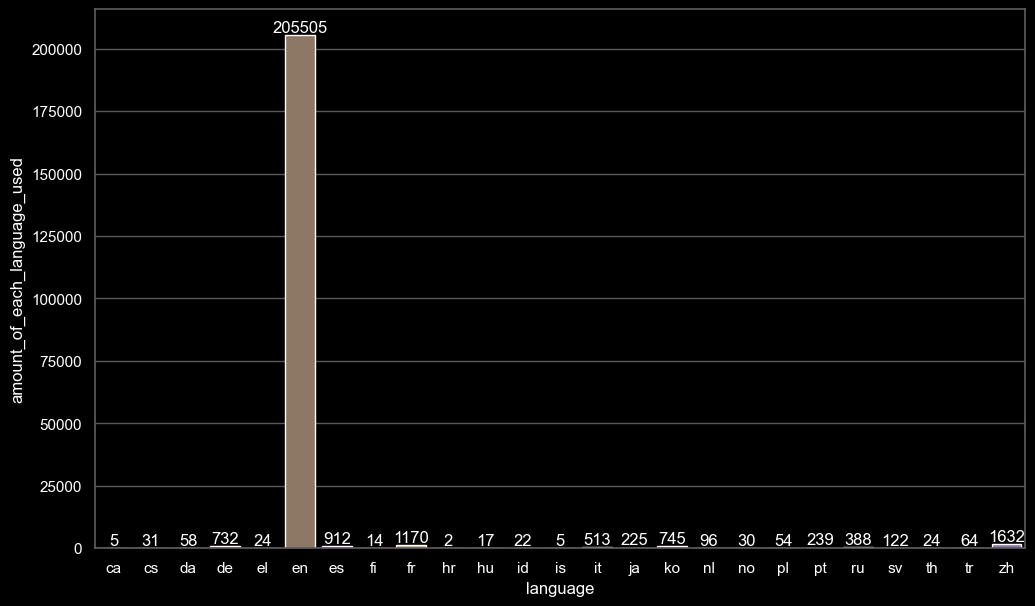

In [60]:
aux = df_eda[['language', 'country_destination']].groupby('language').count().reset_index().rename(columns={'country_destination': 'amount_of_each_language_used'})
bar_plot_values_on_top(x='language', y='amount_of_each_language_used', aux=aux)

In [61]:
pct = round(aux.loc[aux['language']=='en', 'amount_of_each_language_used'].values[0]/aux['amount_of_each_language_used'].sum()*100, 2)
print(f'The percentage of people that use american-english as the language to book their reservations is {pct}%, across all destinations.')

The percentage of people that use american-english as the language to book their reservations is 96.65%, across all destinations.


#### 6.3. **Multivariate Analysis**

This section is used to remove variables with really high correlation with one another, by applying Pearson Correlation (numerical variables) and Cramér's V (categorical variables).

In [62]:
# empty list to store cols to be dropped after correlations (pearson and cramer's v)
cols_drop_after_corr = []

6.3.1. **Numerical**

In order to check correlation between all numerical variables in the dataset a Pearson Correlation will be displayed below:

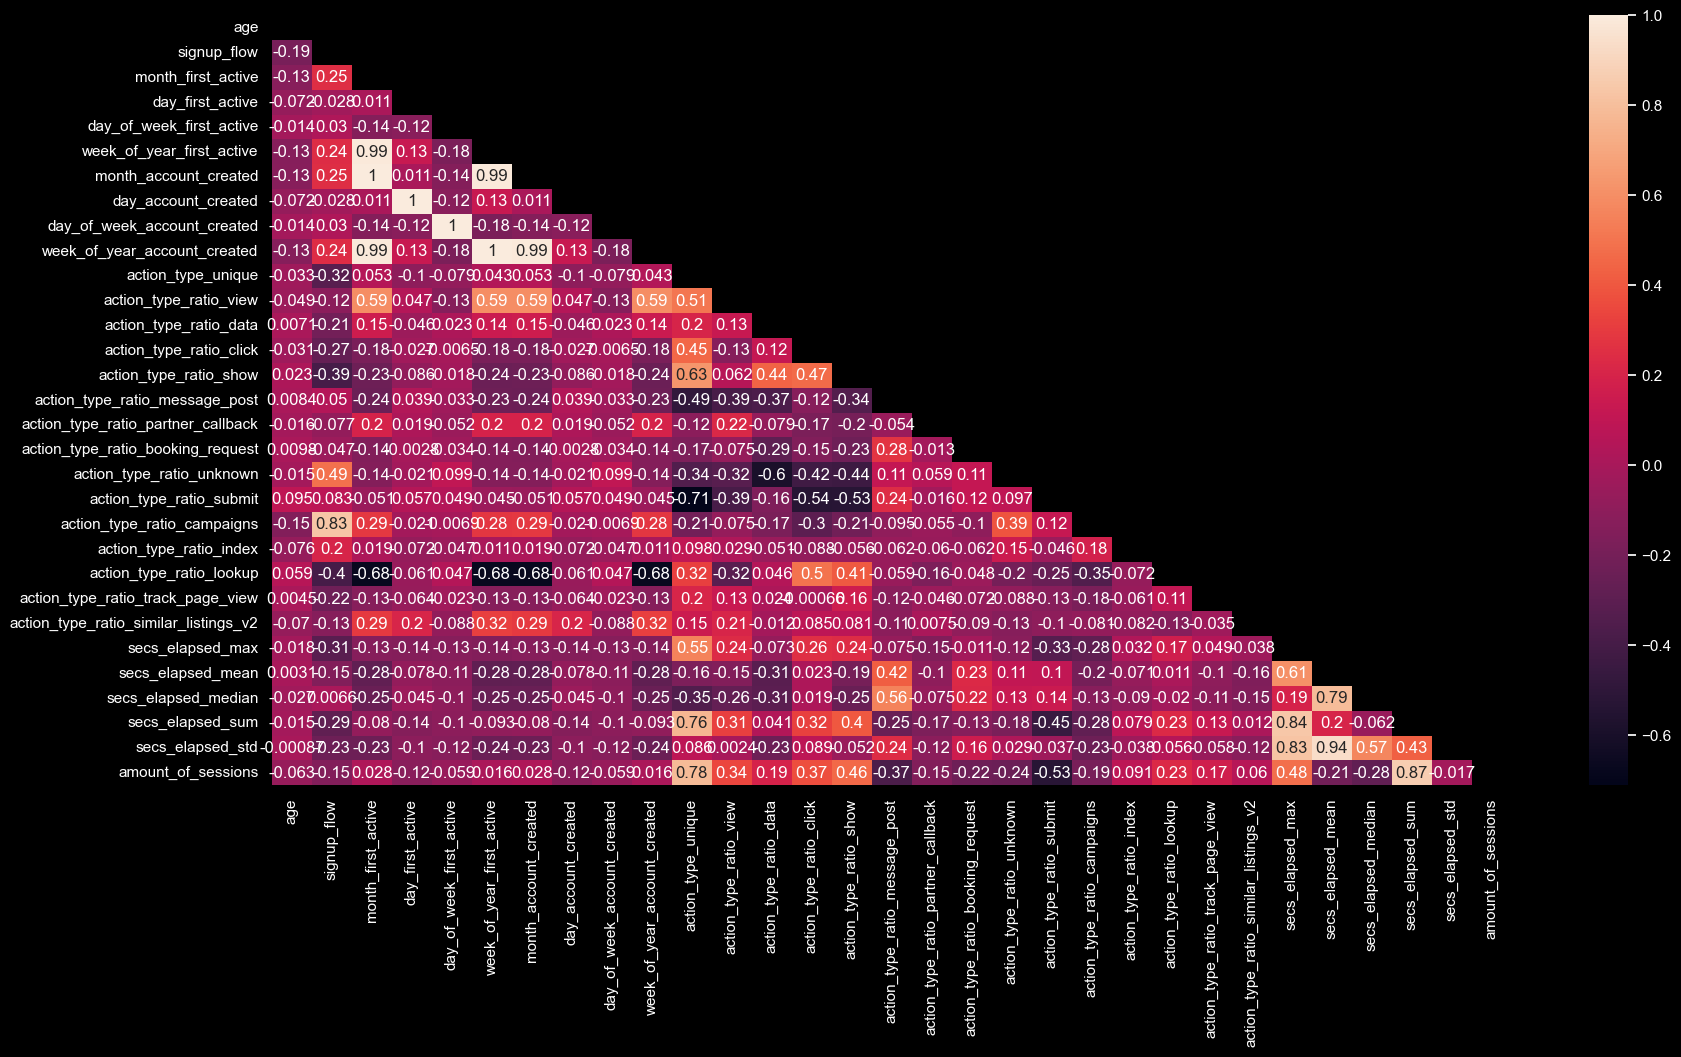

In [63]:
num_attributes = df6.select_dtypes(include=['int64', 'float'])
corr = num_attributes.corr(method='pearson').corr() # Pearson Corr
mask = np.triu(corr) # Cleaner heatmap - Only plotting the lower triangle

plt.figure(figsize=(20,10)) # Heatmap size
sns.heatmap(corr, annot=True, mask=mask);

Any pair of variables with correlation equal to 1 are having one of them manually removed 

**Pair of variables with correlation = 1**:
- month_account_created - month_first_active
- day_account_created - day_first_active
- day_of_week_account_created - day_of_week_first_active
- week_of_year_account_created - week_of_year_first_active

**Variables removed**: 
- month_first_active
- day_account_created
- day_of_week_account_created
- week_of_year_first_active

These variables were removed randomly, as there's no way of knowing which one would be better for modeling.

In [64]:
numerical_drop = ['month_first_active', 
                 'day_account_created', 
                 'day_of_week_account_created', 
                 'week_of_year_first_active']

for i in numerical_drop:
    cols_drop_after_corr.append(i)

6.3.2. **Categorical**

An interesting technique to use whenever categorical variable have many unique values is to check whether some variables have high correlation from one to another. It can be done via Cramér's V correlation matrix: 

<AxesSubplot: >

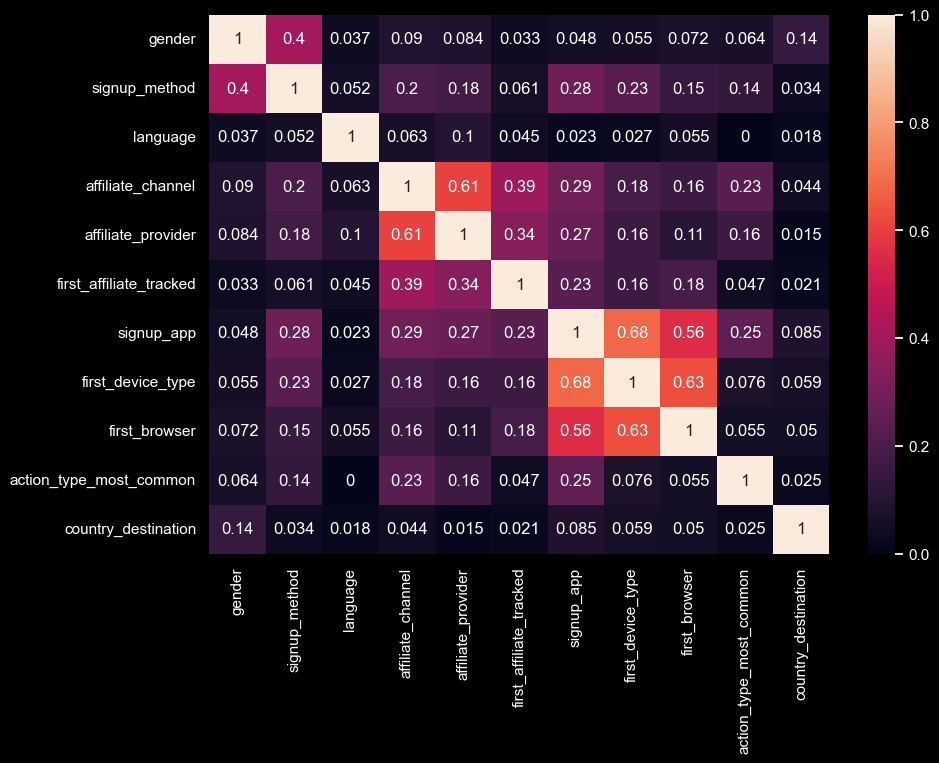

In [65]:
df6_cat_att = df6.select_dtypes(exclude=['int64', 'float', 'datetime64[ns]'])
cramers_v_heatmap(df6_cat_att)

Only two pair of variables had their correlation higher than 0.6:

- affiliate_provider - affiliate_channel
- first_device_type - first_browser

Despite these correlations being moderate, it's possible to keep only one of each variable, due to its nature: **affiliate_provider** and **affiliate_channel** represent very similar actions/phenomena, the same goes for **first_device_type** and **first_browser**.

The ones with the least amount of unique values will be kept.

In [66]:
print(df6['affiliate_provider'].unique())
print(df6['affiliate_channel'].unique())

['direct' 'google' 'other' 'bing' 'facebook-open-graph' 'facebook'
 'padmapper' 'email-marketing' 'gsp' 'yahoo' 'vast' 'yandex' 'naver'
 'meetup' 'baidu' 'craigslist' 'daum']
['direct' 'content' 'api' 'sem-non-brand' 'sem-brand' 'other' 'seo'
 'remarketing']


In [67]:
print(df6['first_device_type'].unique())
print(df6['first_browser'].unique())

['Mac Desktop' 'Windows Desktop' 'Other/Unknown' 'iPad' 'Desktop (Other)'
 'iPhone' 'Android Phone' 'Android Tablet' 'SmartPhone (Other)']
['Safari' 'Chrome' '-unknown-' 'Firefox' 'IE' 'Mobile Safari' 'Chromium'
 'Android Browser' 'IE Mobile' 'Chrome Mobile' 'Mobile Firefox'
 'AOL Explorer' 'Opera' 'Silk' 'Apple Mail' 'Sogou Explorer' 'Maxthon'
 'BlackBerry Browser' 'Iron' 'Outlook 2007' 'IceWeasel' 'SiteKiosk'
 'Googlebot' 'Yandex.Browser' 'Pale Moon' 'RockMelt' 'CoolNovo' 'Mozilla'
 'IceDragon' 'SeaMonkey' 'TheWorld Browser' 'Opera Mini']


In [68]:
categorical_drop = ['affiliate_provider',
                    'first_browser'] 

for i in categorical_drop:
    cols_drop_after_corr.append(i)

6.2.3. **Removing variables**

In [69]:
df6 = df6.drop(cols_drop_after_corr, axis=1)

## 7. **Data Preparation**

In [70]:
df7 = df6.copy()

**Variables that will be rescaled**:
- age
- signup_flow
- action_type_unique
- secs_elapsed_max
- secs_elapsed_mean
- secs_elapsed_median
- secs_elapsed_sum
- secs_elapsed_std
- amount_of_sessions

**Variables that will be encoded**:
- gender                       
- signup_method  
- language            
- affiliate_channel           
- first_affiliate_tracked       
- signup_app                   
- first_device_type      
- action_type_most_common     

**Variables that will be transformed, due to their cyclical behavior**:
- day_of_week_first_active
- month_account_created
- day_first_active
- week_of_year_account_created
       
*other variables will remain the same, since they already go from 0 to 1*

#### 7.1. **Rescaling**

There are mainly two Feature Scaling methods in ML: Rescaling and Standardization. **Rescaling** uses either Robust Scaler, which is used to deal with outliers:

${x}' =  \frac{x_{i} - Q_{1}(x)}{Q_{3}(x)- Q_{1}(x)}$

or Min Max Scaler, which can be used when no significant outliers are present a:

${x}' =  \frac{x - x_{min}}{x_{max} - x_{min}}$

In the other hand, **Standardization** is applied when the variable follows an approximately normal distribution and no significant outliers are present:

${x}' =  \frac{x_{i} - \mu}{\sigma}$

*${x}'$ is the new value for each observation*

Robust Scaler:
- age
- signup_flow
- secs_elapsed_median

Min Max Scaler
- secs_elapsed_max
- secs_elapsed_mean
- secs_elapsed_sum
- secs_elapsed_std
- amount_of_sessions

Standard Scaler:
- action_type_unique

In [71]:
# StandardScaler
ss_action_type_unique = StandardScaler()
df7['action_type_unique'] = ss_action_type_unique.fit_transform(df7[['action_type_unique']].values)
# pickle.dump(ss_action_type_unique, open('scalers/ss_action_type_unique.pkl', 'wb')) # Saving for deployment

# RobustScaler
rs_age = RobustScaler()
df7['age'] = rs_age.fit_transform(df7[['age']].values)
# pickle.dump(rs_age, open('scalers/rs_age.pkl', 'wb')) # Saving for deployment

rs_signup_flow = RobustScaler()
df7['signup_flow'] = rs_signup_flow.fit_transform(df7[['signup_flow']].values)

rs_secs_elapsed_median = RobustScaler()
df7['secs_elapsed_median'] = rs_secs_elapsed_median.fit_transform(df7[['secs_elapsed_median']].values)
# pickle.dump(rs_secs_elapsed_median, open('scalers/rs_secs_elapsed_median.pkl', 'wb')) # Saving for deployment

# MinMaxScaler
mm_secs_elapsed_max = MinMaxScaler()
df7['secs_elapsed_max'] = mm_secs_elapsed_max.fit_transform(df7[['secs_elapsed_max']].values)
# pickle.dump(mm_secs_elapsed_max, open('scalers/mm_secs_elapsed_max.pkl', 'wb')) # Saving for deployment

mm_secs_elapsed_mean = MinMaxScaler()
df7['secs_elapsed_mean'] = mm_secs_elapsed_mean.fit_transform(df7[['secs_elapsed_mean']].values)
# pickle.dump(mm_secs_elapsed_mean, open('scalers/mm_secs_elapsed_mean.pkl', 'wb')) # Saving for deployment

mm_secs_elapsed_sum = MinMaxScaler()
df7['secs_elapsed_sum'] = mm_secs_elapsed_sum.fit_transform(df7[['secs_elapsed_sum']].values)
# pickle.dump(mm_secs_elapsed_sum, open('scalers/mm_secs_elapsed_sum.pkl', 'wb')) # Saving for deployment

mm_secs_elapsed_std = MinMaxScaler()
df7['secs_elapsed_std'] = mm_secs_elapsed_std.fit_transform(df7[['secs_elapsed_std']].values)
# pickle.dump(mm_secs_elapsed_std, open('scalers/mm_secs_elapsed_std.pkl', 'wb')) # Saving for deployment

mm_amount_of_sessions = MinMaxScaler()
df7['amount_of_sessions'] = mm_amount_of_sessions.fit_transform(df7[['amount_of_sessions']].values)
# pickle.dump(mm_amount_of_sessions, open('scalers/mm_amount_of_sessions.pkl', 'wb')) # Saving for deployment

#### 7.2. **Encoding**

One Hot Encoding will be applied to gender, signup_method, signup_app, affiliate_channel, first_affiliate_tracked, first_device_type, since those have fewer uniques values. As for language and action_type_most_common Target Encoding will be applied, because these two variables have both 24 and 14 unique values.

In [72]:
df7_cat_attributes = df7.select_dtypes(exclude=['int64', 'float', 'datetime64[ns]'])
df7_cat_attributes.describe()

,gender,signup_method,language,affiliate_channel,first_affiliate_tracked,signup_app,first_device_type,action_type_most_common,country_destination
count,58956,58956,58956,58956,58956,58956,58956,58956,58956
unique,4,3,24,8,7,4,9,14,12
top,-unknown-,basic,en,direct,untracked,Web,Mac Desktop,view,NDF
freq,30195,44090,56748,37460,31522,45416,22304,52296,35987


In [73]:
# One Hot Encoding 
df7 = pd.get_dummies(df7, prefix=['gender'], columns=['gender'])
df7 = pd.get_dummies(df7, prefix=['signup_method'], columns=['signup_method'])
df7 = pd.get_dummies(df7, prefix=['signup_app'], columns=['signup_app'])
df7 = pd.get_dummies(df7, prefix=['affiliate_channel'], columns=['affiliate_channel'])
df7 = pd.get_dummies(df7, prefix=['first_affiliate_tracked'], columns=['first_affiliate_tracked'])
df7 = pd.get_dummies(df7, prefix=['first_device_type'], columns=['first_device_type'])

# FrequencyEncoder
fe_language = (df7.groupby('language').size()) / len(df7)
df7['language'] = df7['language'].apply(lambda x : fe_language[x])

fe_action_type_most_common = (df7.groupby('action_type_most_common').size()) / len(df7)
df7['action_type_most_common'] = df7['action_type_most_common'].apply(lambda x : fe_action_type_most_common[x])

#### 7.3. **Transformation**

<p align="justify"> 
Some date/period variables have a cyclical nature, such as days, months, week of year, and so on. If no transformation is applied to those features there's information loss on the model, as it would count the 12th month on each year really far from the first month, however they are only one month apart. To overcome this problem, a <b> Nature Cyclical Transformation </b> can be used, where each period is a combination of sin and cos. </p>

<p align="justify"> 
In this dataset the following variables have that cyclical behavior:

- <b> day_of_week_first_active
- month_account_created
- day_first_active
- week_of_year_account_created</b> </p>

In [74]:
cols = {'day_of_week_first_active': 7, # passing the cycle for each period       
        'month_account_created' : 12, 
        'day_first_active': 30,
        'week_of_year_account_created': 52}

for period, cycle in cols.items():
    nature_encode(df7, period, cycle)

In [75]:
# no need to keep these columns, since we already have their sin and cos
cols_drop_enc = ['day_of_week_first_active', 
                 'month_account_created', 
                 'day_first_active',         
                 'week_of_year_account_created']

df7 = df7.drop(cols_drop_enc, axis=1)

## 8. **Feature Selection**

In [76]:
df8 = df7.copy()

In [77]:
le = LabelEncoder()
df8['country_destination'] = le.fit_transform(df8['country_destination'])
pickle.dump(le, open('scalers/le.pkl', 'wb')) # Saving for deployment

X_train_n = df8.drop(columns=['country_destination']).copy()
y_train_n = df8['country_destination'].copy()

#### 8.1. **Random Forest as a Feature Selector**

<p align="justify"> Random Forest (RF) implements bagging method and decision trees, by resampling a random subset of the features and fitting each subset by using a decision tree. Finally, the most voted class for each observation is chosen as the RF prediction. Due to its nature, RF is often used as a feature selector, since each tree calculates the importance of a feature according to its power in increasing leaves' pureness.

A function named <b>feature_importances</b> was created in order to provide a list and a plot of ranked importances, given by the chosen model (RF in this case). 

<i> The function definition is available at 1.2. Helper Functions section. </i> </p>

Feature Ranking:

                                 feature  importance
0                                    age    0.070074
0      action_type_ratio_booking_request    0.053741
0                       secs_elapsed_max    0.043565
0                       secs_elapsed_sum    0.042534
0                    secs_elapsed_median    0.042280
..                                   ...         ...
0                   signup_method_google    0.000242
0                           gender_OTHER    0.000192
0      first_affiliate_tracked_marketing    0.000168
0   first_device_type_SmartPhone (Other)    0.000047
0      first_affiliate_tracked_local ops    0.000022

[68 rows x 2 columns]


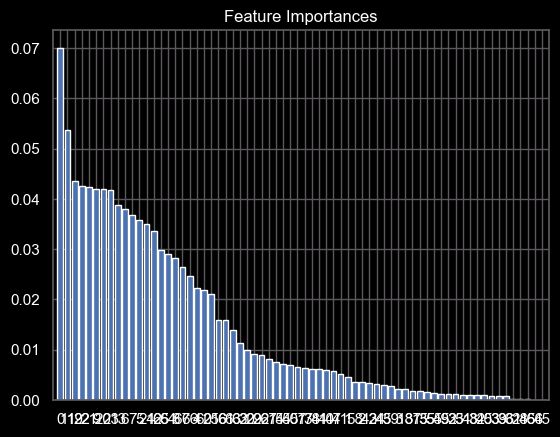

In [78]:
# Defining the RF model
rf = RandomForestClassifier(n_estimators=250, random_state=42, n_jobs=-1)

# Using the feature_importances function
feature_importances_df = feature_importances(rf, X_train_n, y_train_n)

<p align="justify"> So we could keep a smaller number of features half the features were selected, leading to <b>34 features</b>. This number of features is quite reasonable for our sample size (N), making our model not prone to overfitting, as the later results in the test dataset will show. According to <a href="https://academic.oup.com/bioinformatics/article/21/8/1509/249540">Hua's paper</a> the maximum feature size should be around <span>&#8730;N</span>.</p>

In [79]:
cols_selected_rf = ['age',
                    'action_type_ratio_booking_request',
                    'secs_elapsed_max',
                    'secs_elapsed_sum',
                    'secs_elapsed_median',
                    'action_type_ratio_message_post',
                    'secs_elapsed_mean',
                    'secs_elapsed_std',
                    'action_type_ratio_submit',
                    'action_type_ratio_data',
                    'action_type_ratio_click',
                    'action_type_ratio_view',
                    'amount_of_sessions',
                    'action_type_ratio_unknown',
                    'day_first_active_cos',
                    'day_first_active_sin',
                    'action_type_ratio_show',
                    'week_of_year_account_created_cos',
                    'week_of_year_account_created_sin',
                    'action_type_unique',
                    'day_of_week_first_active_sin',
                    'gender_-unknown-',
                    'action_type_ratio_lookup',
                    'day_of_week_first_active_cos',
                    'month_account_created_cos',
                    'month_account_created_sin',
                    'signup_method_facebook',
                    'signup_method_basic',
                    'gender_FEMALE',
                    'gender_MALE',
                    'action_type_ratio_campaigns',
                    'first_device_type_Mac Desktop',
                    'first_affiliate_tracked_untracked',
                    'first_device_type_Windows Desktop']

## 9. **Testing Dimensionality Reduction**

A few dimensionality reduction techniques will be tested, in order to improve the model's performance.

In [80]:
X_train_ml = X_train_n[cols_selected_rf]
y_train_ml = y_train_n.copy()

#### 9.1. **PCA**

<BarContainer object of 34 artists>

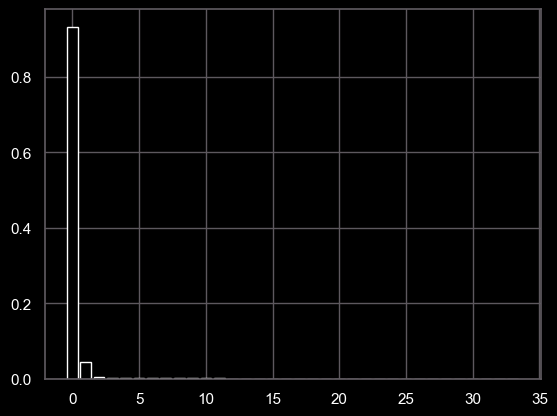

In [81]:
pca_train = PCA(n_components=X_train_ml.shape[1])
principal_components = pca_train.fit_transform(X_train_ml)
df_pca_train = pd.DataFrame(principal_components)

features = range(pca_train.n_components)
plt.bar(features, pca_train.explained_variance_ratio_, color='black')

In [82]:
df_pca_train = df_pca_train.iloc[: , :12]

rs = RobustScaler()
df_pca_train[0] = rs.fit_transform(df_pca_train[0].values.reshape(-1, 1))
df_pca_train[1] = rs.fit_transform(df_pca_train[1].values.reshape(-1, 1))

lista = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


mm = MinMaxScaler()
for i in lista:
    df_pca_train[i] = mm.fit_transform(df_pca_train[i].values.reshape(-1, 1))

#### 9.2. **Uniform Manifold Approximation and Projection (UMAP)**

<p align="justify"> UMAP, just like t-SNE, is a non-linear dimensionality reduction technique. Both these methods capture non-linear structure in high dimensional data, which means that if two points are close in the high dimensional space, they have a high probability of being close in the low dimensional space. Nonetheless, UMAP usually works better in comparison to t-SNE, because it's much faster, captures the global structure better, and it can be used in data preprocessing for later use in ML models, while t-SNE's use is mostly data visualization. </p>

In [83]:
# UMAP
mapper=umap.UMAP(random_state=42).fit(X_train_ml, y_train_n)
umap_component= mapper.transform(X_train_ml)

df_umap = pd.DataFrame()

# Embedding
df_umap['embedding_x'] = umap_component[:, 0] # x component
df_umap['embedding_y'] = umap_component[:, 1] # y component

mm = MinMaxScaler()
for i in df_umap.columns:
    df_umap[i] = mm.fit_transform(df_umap[i].values.reshape(-1, 1))

*Both PCA and UMAP didn't improve the model's performance, therefore those weren't used in the final ML model.*

## 10. **ML Modelling**

<p align="justify"> As the goal in this project is to predict not only the most likely next booking destination for each user, but the five most likely ones the <b>Normalized discounted cumulative gain (NDCG) at rank K</b> was chosen.</p>
 
<p align="justify"> NDCG at K <i>"measures the performance of a recommendation system based on the graded relevance of the recommended entities. It varies from 0.0 to 1.0, with 1.0 representing the ideal ranking of the entities."</i> Therefore, for this instance (where k equals 5), it not only measures how well we can predict the five most likely next booking locations for each user, but also how well can rank them from the most likely to the least.</p>

#### 10.1. **Logistic Regression**

In [84]:
lr = LogisticRegression(max_iter=10000, random_state=42) 
lr_result = cross_validation(lr, X_train_ml, y_train_n, k=5)

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


#### 10.2. **Decision Tree**

In [85]:
dt = DecisionTreeClassifier(random_state=42) 
dt_result = cross_validation(dt, X_train_ml, y_train_n, k=5)

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


#### 10.3. **Random Forest**

In [86]:
rf = RandomForestClassifier(random_state=42)
rf_result = cross_validation(rf, X_train_ml, y_train_n, k=5)

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


#### 10.4. **ExtraTrees**

In [87]:
et = ExtraTreesClassifier(random_state=42)
et_result = cross_validation(et, X_train_ml, y_train_n, k=5)

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


#### 10.5. **AdaBoost**

In [88]:
ad = AdaBoostClassifier(random_state=42)
ad_result = cross_validation(ad, X_train_ml, y_train_n, k=5)

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


#### 10.6. **XGBoost**

In [89]:
xgb = XGBClassifier(random_state=42)
xgb_result = cross_validation(xgb, X_train_ml, y_train_n, k=5)

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


#### 10.6. **LGBM**

In [90]:
lgbm = LGBMClassifier(random_state=42)
lgbm_result = cross_validation(lgbm, X_train_ml, y_train_n, k=5)

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


#### 10.7. **Models Summary**

In [91]:
modeling_result = pd.concat([lr_result, dt_result, rf_result, et_result, ad_result, xgb_result, lgbm_result])
modeling_result.sort_values(by='NDCG Score', ascending=False)

,Model,NDCG Score
0,LGBMClassifier,0.8496 +/- 0.0006
0,XGBClassifier,0.8482 +/- 0.0004
0,RandomForestClassifier,0.8451 +/- 0.0006
0,AdaBoostClassifier,0.8429 +/- 0.0019
0,ExtraTreesClassifier,0.839 +/- 0.0008
0,LogisticRegression,0.8378 +/- 0.001
0,DecisionTreeClassifier,0.7242 +/- 0.0023


<p align="justify"> The <b>Light GBM Classifier</b> model was chosen for hyperparameter tuning, since it's fast to train and tune, whilst being also the one with the best result without any tuning. In addition to that, it's much better for deployment, as it's much lighter than a XGBoost or Random Forest for instance, especially given the fact that we're using a free deployment cloud.</p>

## 11. **Hyperparameter Fine Tuning**

<p align="justify"> An important task in ML modeling is Hyperparameter Tuning, on which the goal is to find the <b>best possible combination of model hyperparameters</b>. This task will be performed fitting the model to the training data, and evaluating it in the test data, which was originally split in section 5.2. But firstly the test dataset has to go through all transformations the training dataset went through: </p>

In [92]:
test_le = LabelEncoder()
df_test['country_destination'] = test_le.fit_transform(df_test['country_destination'])

X_test = df_test.drop('country_destination', axis=1).copy()
y_test = df_test['country_destination'].copy()

# One Hot Encoding 
X_test = pd.get_dummies(X_test, prefix=['gender'], columns=['gender'])
X_test = pd.get_dummies(X_test, prefix=['signup_method'], columns=['signup_method'])
X_test = pd.get_dummies(X_test, prefix=['signup_app'], columns=['signup_app'])
X_test = pd.get_dummies(X_test, prefix=['affiliate_channel'], columns=['affiliate_channel'])
X_test = pd.get_dummies(X_test, prefix=['first_affiliate_tracked'], columns=['first_affiliate_tracked'])
X_test = pd.get_dummies(X_test, prefix=['first_device_type'], columns=['first_device_type'])

# FrequencyEncoder
fe_language = (X_test.groupby('language').size()) / len(X_test)
X_test['language'] = X_test['language'].apply(lambda x : fe_language[x])

fe_action_type_most_common = (X_test.groupby('action_type_most_common').size()) / len(X_test)
X_test['action_type_most_common'] = X_test['action_type_most_common'].apply(lambda x : fe_action_type_most_common[x])

# RobustScaler
rs_age = RobustScaler()
rs_signup_flow = RobustScaler()
rs_secs_elapsed_median = RobustScaler()
X_test['age'] = rs_age.fit_transform(X_test[['age']].values)
X_test['signup_flow'] = rs_signup_flow.fit_transform(X_test[['signup_flow']].values)
X_test['secs_elapsed_median'] = rs_secs_elapsed_median.fit_transform(X_test[['secs_elapsed_median']].values)

# MinMaxScaler
mm_secs_elapsed_max = MinMaxScaler()
mm_secs_elapsed_mean = MinMaxScaler()
mm_secs_elapsed_sum = MinMaxScaler()
mm_secs_elapsed_std = MinMaxScaler()
mm_amount_of_sessions = MinMaxScaler()
X_test['secs_elapsed_max'] = mm_secs_elapsed_max.fit_transform(X_test[['secs_elapsed_max']].values)
X_test['secs_elapsed_mean'] = mm_secs_elapsed_mean.fit_transform(X_test[['secs_elapsed_mean']].values)
X_test['secs_elapsed_sum'] = mm_secs_elapsed_sum.fit_transform(X_test[['secs_elapsed_sum']].values)
X_test['secs_elapsed_std'] = mm_secs_elapsed_std.fit_transform(X_test[['secs_elapsed_std']].values)
X_test['amount_of_sessions'] = mm_amount_of_sessions.fit_transform(X_test[['amount_of_sessions']].values)

# StandardScaler
ss = StandardScaler()
X_test['action_type_unique'] = ss.fit_transform(X_test[['action_type_unique']].values)

# Transformation
cols = {'day_of_week_first_active': 7,   
        'month_account_created' : 12, 
        'day_first_active': 30,
        'week_of_year_account_created': 52}

for period, cycle in cols.items():
    nature_encode(X_test, period, cycle)

# final X_test
X_test = X_test[cols_selected_rf]

In [93]:
# Inital model without tuning
lgbm = LGBMClassifier(n_estimators=250)
y_pred, df_lgbm = model_eval(lgbm, X_train_ml, y_train_ml, X_test, y_test)
df_lgbm

,Model,NDCG Score
0,LGBMClassifier,0.8514


#### 11.1. **Bayesian Optimization**

<p align="justify"> One Hyperparameter Tuning method is the Bayesian Optimization, which can be performed in python by using the <a href="https://optuna.org/">Optuna</a> library. This is how it works: </p>

- A set of possible model hyperparameters (search space) is defined.
  
- It starts searching random combinations of these parameters and training each model.
  
- Then, Optuna uses a history record of trials to determine which hyperparameter values to try next, by trying to find the most promising hyperparameters to be tuned.
  
- The metrics for each model are saved for latter comparison.

<p align="justify"> Bayesian Optimization is definitely more efficient in comparison to Grid Search and Random Search, since it's much faster than Grid Search, and it goes through better (smarter) hyperparameters combination than Random Search, meaning that it considers hyperparameters differently in terms of model impact. </p>

In [94]:
# # Defining an objective function to be optimized
# def bayesian_opt_objective(trial):
#     n_estimators = trial.suggest_int('n_estimators', 300, 1200, step=100)
#     learning_rate = trial.suggest_float('learning_rate', 0.005, 0.05, step=0.005)
#     num_leaves = trial.suggest_int('num_leaves', 35, 80, step=5)
#     max_depth = trial.suggest_int('max_depth', 5, 10, step=1)
#     min_child_samples = trial.suggest_int('min_child_samples', 50, 100, step=5)
#     min_child_weight = trial.suggest_float('min_child_weight', 0.001, 0.0985, step=0.0025)
#     subsample = trial.suggest_float('subsample', 0.7, 0.95, step=0.05)
#     colsample_bytree = trial.suggest_float('colsample_bytree', 0.75, 0.95, step=0.05)
    
#     lgbm = LGBMClassifier(n_estimators = n_estimators,
#                           learning_rate = learning_rate, 
#                           num_leaves = num_leaves, 
#                           max_depth = max_depth,
#                           min_child_samples = min_child_samples,
#                           min_child_weight = min_child_weight,
#                           subsample = subsample,
#                           colsample_bytree = colsample_bytree,
#                           random_state=42).fit(X_train_ml, y_train)
#     # Prediction
#     y_pred = lgbm.predict_proba(X_test)
        
#     # NDCG Score
#     ndcg = ndcg_score(y_test, y_pred)   

#     return ndcg

In [95]:
# study = optuna.create_study(direction='maximize') # maximizing the precision at k
# study.optimize(bayesian_opt_objective, n_trials=100); # optimizing the defined function and setting the number of trials
# trial = study.best_trial

# print(f'Best NDCG Score = {trial.value}')
# print(f'Best Hyperparameters = {trial.params}')

#### 11.2. **Final Model**

Out of the tested hyperparameters, Bayesian Optimization with Optuna provided the following as the best ones:

| Hyperparameter | Definition | Best Value |
|:---:|---|:---:|
| n_estimators | Number of boosting iterations | 300 |
| learning_rate | Shrinkage rate | 0.02 |
| num_leaves | max number of leaves in one tree | 45 |
| max_depth | Limit the max depth for tree model | 8 |
| min_child_samples | Minimal number of data in one leaf | 55 |
| min_child_weight | Minimal sum hessian in one leaf | 0.04 |
| subsample | Used to randomly select part of data without resampling| 0.8 |
| colsample_bytree| Used to randomly select a subset of features on each iteration| 0.85 |

In [96]:
# Tuned Parameters
best_param =  {'n_estimators': 300,
               'learning_rate': 0.02,
               'num_leaves': 45,
               'max_depth': 8,
               'min_child_samples': 55,
               'min_child_weight': 0.04,
               'subsample': 0.8,
               'colsample_bytree': 0.85}

# Final Model
model_lgbm_final = LGBMClassifier(**best_param)

y_pred_eval, df_model_eval = model_eval(model_lgbm_final, X_train_ml, y_train_ml, X_test, y_test)
# pickle.dump(model_lgbm_final, open('model/lgbm_airbnb.pkl', 'wb'))  # Saving for deployment

df_model_eval # final model score

,Model,NDCG Score
0,LGBMClassifier,0.8542


## 12. **Model Deployment and Results**

<p align="justify"> The model deployment was performed in three steps: 
 
- <p align="justify"> <b>Step 1</b>: The original data (both datasets in <a href="https://github.com/brunodifranco/project-airbnb-classification#2-data-overview"> Section 2</a>) was saved in a PostgreSQL Database from <a href="https://neon.tech/">Neon.tech</a>. </p>
 
 - <p align="justify"> <b>Step 2</b>: A Flask application was built using <a href="https://render.com/"> Render Cloud </a>, on which it extracts the original data from that PostgreSQL Database, cleans and transforms the data, loads the saved ML model, creates predictions for each user and adds these predictions back in a different table inside the same Database. Let's name this table 'df_pred' for the sake of the explanation.</p>

 - <p align="justify"> <b>Step 3</b>: Streamlit retrieves the df_pred data from the Database and displays it in a table inside Streamlit with filters, where you can find the five most likely destinations predictions for the 61 thousand USA Airbnb users. In addition to that, graphical analysis from the predictions were built, split by age, gender and overall analysis. This is the project's <b>Data Science Product</b>, and it can be accessed from anywhere in a Streamlit App.</p>


<div align="center">
<table>
<tr><th>Click on the respective icon to access the link</th></tr>
<tr><td>
 
 <div align="center">

|         **Streamlit App**        | **Flask App** |
|:------------------------:|:-------------:|
|        [![Streamlit App](https://img.shields.io/badge/Streamlit-FF4B4B?style=for-the-badge&logo=Streamlit&logoColor=white)](https://airbnb.streamlit.app/)       |     [![Flask](https://img.shields.io/badge/Flask-000000?style=for-the-badge&logo=flask&logoColor=white)](https://airbnb-predict.onrender.com)  | 
</div>
 
 </td></tr> </table>
</div>

<p align="justify"> The Flask App is particularly useful for when new data comes in, as we can get new predictions with a click of a button, so it can be later retrieved by the Streamlit App. The Streamlit App code is available <a href="https://github.com/brunodifranco/airbnb-app">here</a> and the Flask App code can be seen <a href="https://github.com/brunodifranco/airbnb-predict">here</a>.</p>

<p align="justify"><i>Because the deployment was made in a free cloud (Render Cloud) the Flask App's functionality could be slow, in the other hand, the main deployment product, which is the Streamlit App, should work quickly.</i></p>

## 13. **Conclusion**

 <p align="justify"> <b>We managed to provide a list of the five most likely destinations predictions for 61 thousand USA Airbnb users, as well as graphical analysis of the predictions by age, gender and overall analysis. This can all be found in a Streamlit App, for better visualization.</b> Also, a Flask application was built for when new data comes in, making it possible to get new predictions easily. In addition to that, three interesting and useful insights were found through Exploratory Data Analysis (EDA), so that those can be properly used by Airbnb. </p>

## 14. **Appendix : **Data Balance****

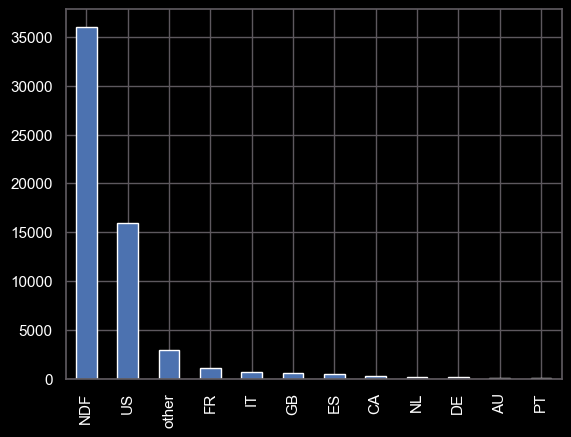

In [100]:
y_train.value_counts().sort_values(ascending=False).plot(kind='bar');

<p align="justify"> The data is quite unbalanced, as the percentage of people that didn't decide a destination (ndf) + USA destinations is about 87,41% of the data. </p>

<p align="justify"> SMOTE in combination with Tomeklink was used in this dataset to balance it. Smote and Tomeklink are two data balancing techniques, and combined they set all classes to have the exact same number of observations, which isn't realistic. To fix this, a ratio will be set so that it could be a better representation of reality. This is done by increasing the number of observations only for the minority classes, which still keeps the classes orders in terms of observations amount. </p>

<p align="justify"> <b> However the model performance (NDCG Score) using the balanced dataset was significantly reduced compared to the unbalanced dataset in both cross-validation train and test. That's likely due to data overlap amongst the country_destination variable, which can be seen using UMAP. </b> </p>

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

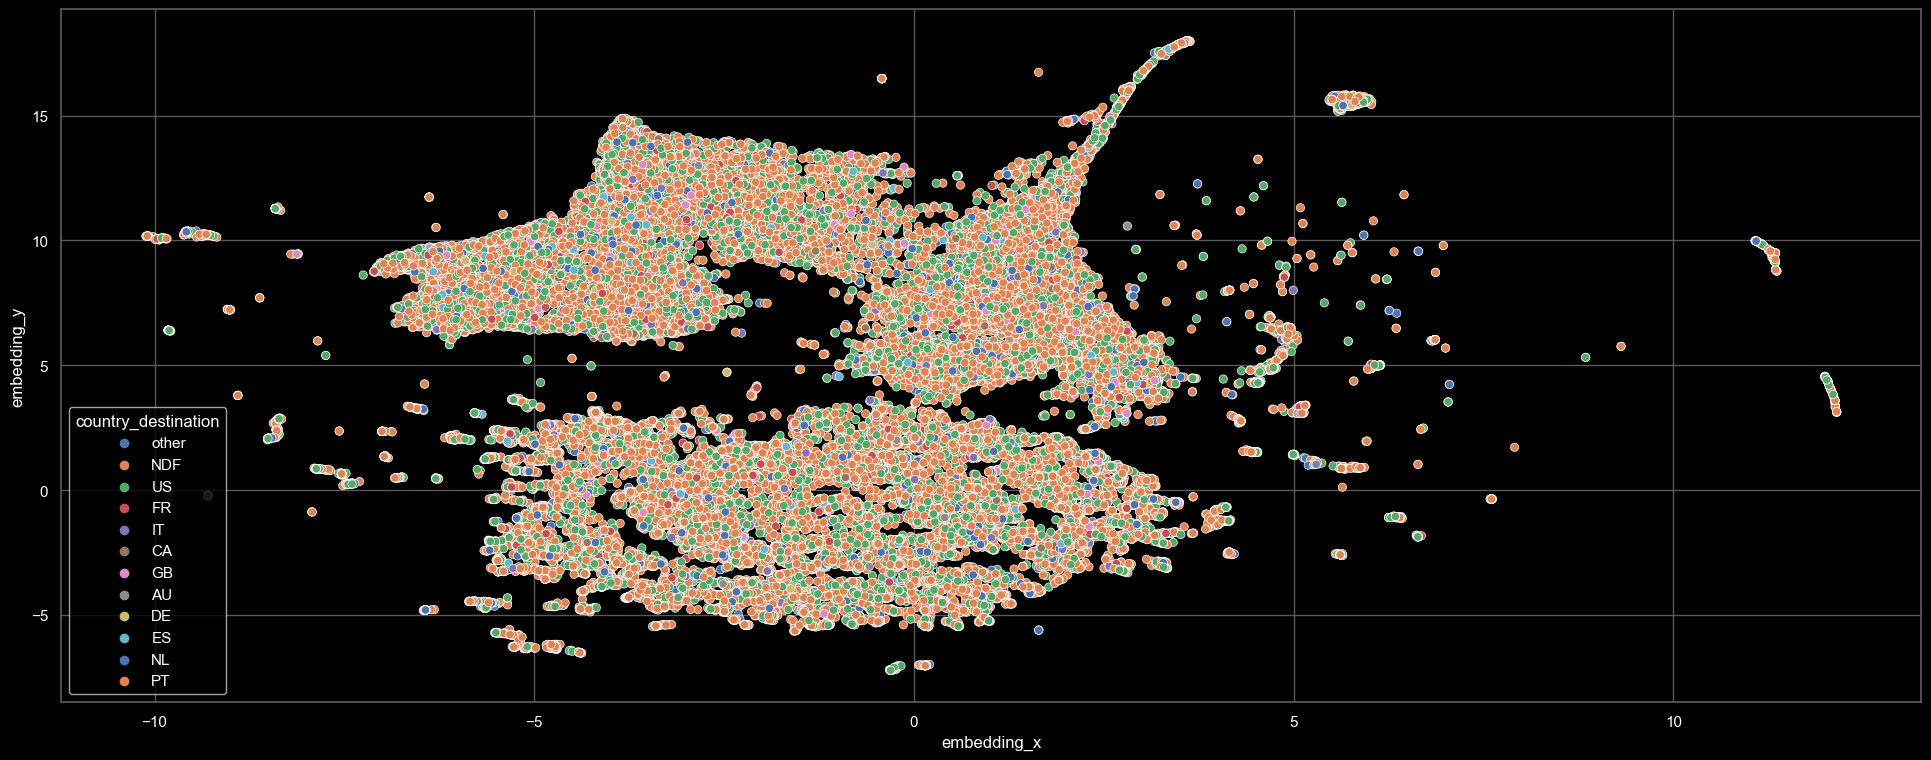

In [101]:
# UMAP
mapper=umap.UMAP(random_state=42).fit(X_train_ml, y_train_n)
umap_component= mapper.transform(X_train_ml)

df_umap = pd.DataFrame()

# Embedding
df_umap['embedding_x'] = umap_component[:, 0] # x component
df_umap['embedding_y'] = umap_component[:, 1] # y component
df_umap['country_destination'] = y_train # adding the labels

# Plotting
plt.figure(figsize=(24,9))
sns.scatterplot(x='embedding_x', 
                y='embedding_y',
                hue='country_destination',                
                palette='deep',
                data=df_umap)